## Sharing Bike Usage Prediction in South Korea with Data Combination
The main purpose of this project is to forecast the hourly bike usage in Seoul, South Korea. Two datasets, one is from US and the other one is from KR will be used. US data and KR data will be combined as a combined data and KR data will be the other input data for models. Poisson GLM and Negative Binomial GLM will be used to develop models. 

The analysis will be split into 3 parts:
* Data Cleaning
* Data Exploration (including data split)
* Model Building

### Data Cleaning
we are going to use two different datasets. At first, we need to adjust the weather data to be in the same metrics. Additionally, the US dataset lacks some weather data that KR data has so they will be added from another US weather dataset.
1. Prepare the US weather dataset and convert the weather units.
2. Cleaning the US bike data and Seoul bike data

In [1]:
import numpy as np
import pandas as pd
import random

from datetime import datetime

## for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## for selecting feature interaction
from sklearn.metrics.cluster import normalized_mutual_info_score

## for model building
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
from scipy import stats

## for GLM visualisation
from statsmodels.graphics.api import abline_plot
from statsmodels import graphics

#### 1. Cleaning US weather data

In [2]:
# read data
df_weather = pd.read_csv('USweather1.csv')

In [3]:
df_weather.head()

Address    Date time  Minimum Temperature  Maximum Temperature  \
0  Washington,DC,USA  1/1/11 0:00                 37.5                 37.5   
1  Washington,DC,USA  1/1/11 1:00                 35.2                 35.2   
2  Washington,DC,USA  1/1/11 2:00                 35.6                 35.6   
3  Washington,DC,USA  1/1/11 3:00                 36.9                 36.9   
4  Washington,DC,USA  1/1/11 4:00                 35.7                 35.7   

   Temperature  Dew Point  Relative Humidity  Heat Index  Wind Speed  \
0         37.5       31.8              79.61         NaN         0.4   
1         35.2       30.4              82.44         NaN         0.4   
2         35.6       30.4              81.31         NaN         0.6   
3         36.9       30.5              77.58         NaN         0.4   
4         35.7       30.3              80.41         NaN         0.6   

   Wind Gust  ...  Visibility  Cloud Cover  Sea Level Pressure  Weather Type  \
0        NaN  ...         9.9          0.0              1021.3           NaN   
1        NaN  ...         8.8          0.0              1021.3           NaN   
2        NaN  ...         8.3          0.0              1021.0           NaN   
3        NaN  ...         8.3         24.4              1020.8           NaN   
4        NaN  ...         8.3         20.8              1020.5           NaN   

   Latitude  Longitude               Resolved Address  \
0   38.8904    -77.032  Washington, DC, United States   
1   38.8904    -77.032  Washington, DC, United States   
2   38.8904    -77.032  Washington, DC, United States   
3   38.8904    -77.032  Washington, DC, United States   
4   38.8904    -77.032  Washington, DC, United States   

                            Name Info  Conditions  
0  Washington, DC, United States  NaN       Clear  
1  Washington, DC, United States  NaN       Clear  
2  Washington, DC, United States  NaN       Clear  
3  Washington, DC, United States  NaN       Clear  
4  Washington, DC, United States  NaN       Clear  

[5 rows x 25 columns]

In [4]:
print(df_weather.shape)
df_weather.describe()

(17544, 25)


Minimum Temperature  Maximum Temperature   Temperature     Dew Point  \
count         17543.000000         17543.000000  17543.000000  17543.000000   
mean             60.087870            60.087870     60.087385     46.353043   
std              17.395993            17.395993     17.395816     17.905591   
min              16.700000            16.700000     16.700000     -5.700000   
25%              46.000000            46.000000     46.000000     31.400000   
50%              60.500000            60.500000     60.500000     48.100000   
75%              74.400000            74.400000     74.400000     62.400000   
max             105.100000           105.100000    105.100000     80.400000   

       Relative Humidity   Heat Index    Wind Speed    Wind Gust  \
count       17542.000000  2507.000000  17543.000000  3044.000000   
mean           63.457767    88.928321      7.865388    24.670598   
std            19.192660     6.535860      4.970060     6.522301   
min             8.780000    78.800000      0.000000    16.100000   
25%            48.180000    83.900000      4.600000    19.500000   
50%            63.790000    87.300000      7.400000    23.000000   
75%            79.650000    92.700000     10.500000    28.300000   
max           100.000000   121.200000     40.100000    70.200000   

       Wind Direction   Wind Chill  Precipitation  Precipitation Cover  \
count    17530.000000  5028.000000   17544.000000                  0.0   
mean       191.621050    34.786317       0.004812                  NaN   
std        113.910402     8.294699       0.034521                  NaN   
min          0.000000     3.900000       0.000000                  NaN   
25%         97.000000    29.600000       0.000000                  NaN   
50%        197.000000    35.900000       0.000000                  NaN   
75%        300.000000    41.500000       0.000000                  NaN   
max        360.000000    49.400000       1.440000                  NaN   

       Snow Depth    Visibility   Cloud Cover  Sea Level Pressure  \
count   31.000000  17543.000000  17542.000000        17543.000000   
mean     2.677419      9.368534     66.105655         1016.785316   
std      1.150878      1.557286     33.931537            7.615913   
min      1.180000      0.000000      0.000000          969.600000   
25%      1.970000      9.900000     44.600000         1012.100000   
50%      1.970000      9.900000     81.300000         1016.500000   
75%      3.940000      9.900000     94.600000         1021.600000   
max      5.120000      9.900000    100.000000         1039.800000   

           Latitude     Longitude  Info  
count  1.754400e+04  1.754400e+04   0.0  
mean   3.889040e+01 -7.703200e+01   NaN  
std    1.101373e-12  1.990997e-11   NaN  
min    3.889040e+01 -7.703200e+01   NaN  
25%    3.889040e+01 -7.703200e+01   NaN  
50%    3.889040e+01 -7.703200e+01   NaN  
75%    3.889040e+01 -7.703200e+01   NaN  
max    3.889040e+01 -7.703200e+01   NaN

In [5]:
# check the duplicated data
duplicate = df_weather[df_weather['Date time'].duplicated()]
print(duplicate)

# remove the duplicated data
df_weather['Date time'].duplicated().any()
df_weather.drop_duplicates(subset=['Date time'], inplace=True, keep = 'first')

# check duplicates again
print('duplicated data exists?:', df_weather['Date time'].duplicated().any())

                 Address     Date time  Minimum Temperature  \
7417   Washington,DC,USA  11/6/11 1:00                 38.6   
16153  Washington,DC,USA  11/4/12 1:00                 38.8   

       Maximum Temperature  Temperature  Dew Point  Relative Humidity  \
7417                  38.6         38.6       33.3              81.33   
16153                 38.8         38.8       33.2              80.33   

       Heat Index  Wind Speed  Wind Gust  ...  Visibility  Cloud Cover  \
7417          NaN         0.0        NaN  ...         9.9          0.0   
16153         NaN         3.3        NaN  ...         9.9         45.6   

       Sea Level Pressure  Weather Type  Latitude  Longitude  \
7417               1033.0           NaN   38.8904    -77.032   
16153              1019.1           NaN   38.8904    -77.032   

                    Resolved Address                           Name Info  \
7417   Washington, DC, United States  Washington, DC, United States  NaN   
16153  Washington, DC,

In [6]:
print(df_weather.shape)
df_weather.head()

(17542, 25)


Address    Date time  Minimum Temperature  Maximum Temperature  \
0  Washington,DC,USA  1/1/11 0:00                 37.5                 37.5   
1  Washington,DC,USA  1/1/11 1:00                 35.2                 35.2   
2  Washington,DC,USA  1/1/11 2:00                 35.6                 35.6   
3  Washington,DC,USA  1/1/11 3:00                 36.9                 36.9   
4  Washington,DC,USA  1/1/11 4:00                 35.7                 35.7   

   Temperature  Dew Point  Relative Humidity  Heat Index  Wind Speed  \
0         37.5       31.8              79.61         NaN         0.4   
1         35.2       30.4              82.44         NaN         0.4   
2         35.6       30.4              81.31         NaN         0.6   
3         36.9       30.5              77.58         NaN         0.4   
4         35.7       30.3              80.41         NaN         0.6   

   Wind Gust  ...  Visibility  Cloud Cover  Sea Level Pressure  Weather Type  \
0        NaN  ...         9.9          0.0              1021.3           NaN   
1        NaN  ...         8.8          0.0              1021.3           NaN   
2        NaN  ...         8.3          0.0              1021.0           NaN   
3        NaN  ...         8.3         24.4              1020.8           NaN   
4        NaN  ...         8.3         20.8              1020.5           NaN   

   Latitude  Longitude               Resolved Address  \
0   38.8904    -77.032  Washington, DC, United States   
1   38.8904    -77.032  Washington, DC, United States   
2   38.8904    -77.032  Washington, DC, United States   
3   38.8904    -77.032  Washington, DC, United States   
4   38.8904    -77.032  Washington, DC, United States   

                            Name Info  Conditions  
0  Washington, DC, United States  NaN       Clear  
1  Washington, DC, United States  NaN       Clear  
2  Washington, DC, United States  NaN       Clear  
3  Washington, DC, United States  NaN       Clear  
4  Washington, DC, United States  NaN       Clear  

[5 rows x 25 columns]

In [7]:
# check NaN
df_weather.isna().sum()

Address                    0
Date time                  0
Minimum Temperature        1
Maximum Temperature        1
Temperature                1
Dew Point                  1
Relative Humidity          2
Heat Index             15035
Wind Speed                 1
Wind Gust              14498
Wind Direction            14
Wind Chill             12515
Precipitation              0
Precipitation Cover    17542
Snow Depth             17511
Visibility                 1
Cloud Cover                2
Sea Level Pressure         1
Weather Type           14737
Latitude                   0
Longitude                  0
Resolved Address           0
Name                       0
Info                   17542
Conditions                 1
dtype: int64

* drop columns with too many nan:'Heat Index','Wind Gust', 'Wind Chill', 'Precipitation Cover', 'Weather Type', 'Info'
* drop unnecessary columns:'Latitude', 'Longitude', 'Resolved Address', 'Name','Wind Gust', 'Wind Direction', 'Wind Chill', 'Sea Level Pressure','Name','Conditions', 'Cloud Cover' ,'Minimum Temperature', 'Maximum Temperature'
* fill in average number:'Temperature'(in Fahrenheit), 'Dew Point'(in Fahrenheit), 'Relative Humidity', 'Wind Speed'(Miles Per Hour), 'Precipitation'(Inches), 'Visibility'(but this is for inches)
* fill NAN in 0:'Snow Depth'

In [8]:
df_weather.columns

Index(['Address', 'Date time', 'Minimum Temperature', 'Maximum Temperature',
       'Temperature', 'Dew Point', 'Relative Humidity', 'Heat Index',
       'Wind Speed', 'Wind Gust', 'Wind Direction', 'Wind Chill',
       'Precipitation', 'Precipitation Cover', 'Snow Depth', 'Visibility',
       'Cloud Cover', 'Sea Level Pressure', 'Weather Type', 'Latitude',
       'Longitude', 'Resolved Address', 'Name', 'Info', 'Conditions'],
      dtype='object')

In [9]:
## drop columns with too many nan and unnecessary columns

df_weather.drop(['Address', 'Heat Index','Wind Gust', 'Wind Chill', 'Precipitation Cover', 'Weather Type', 'Info',
                'Latitude', 'Longitude', 'Resolved Address', 'Name','Wind Gust', 'Wind Direction', 'Wind Chill', 
                 'Sea Level Pressure','Name','Conditions', 'Cloud Cover' ,'Minimum Temperature', 
                 'Maximum Temperature'], axis = 1, inplace = True)

In [10]:
## check the remaining coulmns 
df_weather.columns

Index(['Date time', 'Temperature', 'Dew Point', 'Relative Humidity',
       'Wind Speed', 'Precipitation', 'Snow Depth', 'Visibility'],
      dtype='object')

* fill in average number:'Temperature'(in Fahrenheit), 'Dew Point'(in Fahrenheit), 'Relative Humidity', 'Wind Speed'(Miles Per Hour), 'Precipitation'(Inches), 'Visibility'(but this is for Miles)

In [11]:
# use average to fill in the row

nan = df_weather[df_weather['Temperature'].isna()]
print(nan)

                Date time  Temperature  Dew Point  Relative Humidity  \
6414  09/25/2011 07:00:00          NaN        NaN                NaN   

      Wind Speed  Precipitation  Snow Depth  Visibility  
6414         NaN            0.0         NaN         NaN  


In [12]:
df_weather.iloc[6414,1:] = (df_weather.iloc[6413,1:]+df_weather.iloc[6415,1:])/2

In [13]:
df_weather.iloc[6414,:]

Date time            09/25/2011 07:00:00
Temperature                         69.7
Dew Point                          68.05
Relative Humidity                  94.56
Wind Speed                          5.65
Precipitation                          0
Snow Depth                           NaN
Visibility                          7.55
Name: 6414, dtype: object

In [14]:
#fill NAN in 0:'Snow Depth'

df_weather['Snow Depth'].fillna(0, inplace = True)

In [15]:
# check nan again
df_weather.isna().sum()

Date time            0
Temperature          0
Dew Point            0
Relative Humidity    1
Wind Speed           0
Precipitation        0
Snow Depth           0
Visibility           0
dtype: int64

In [16]:
# inspect the nan
nan = df_weather[df_weather['Relative Humidity'].isna()]
nan

Date time  Temperature  Dew Point  Relative Humidity  \
5760  08/29/2011 01:00:00         62.2      74.54                NaN   

      Wind Speed  Precipitation  Snow Depth  Visibility  
5760         4.6            0.0         0.0         9.8

In [17]:
# fill in average relative humidity of 1 row before and 1 row after 

nan = df_weather[df_weather['Relative Humidity'].isna()]
nan

df_weather.iloc[5760,3] = (df_weather.iloc[5759,3]+df_weather.iloc[5761,3])/2
df_weather.iloc[5760,:]

Date time            08/29/2011 01:00:00
Temperature                         62.2
Dew Point                          74.54
Relative Humidity                 72.665
Wind Speed                           4.6
Precipitation                          0
Snow Depth                             0
Visibility                           9.8
Name: 5760, dtype: object

In [18]:
# check nan again
df_weather.isna().sum()

Date time            0
Temperature          0
Dew Point            0
Relative Humidity    0
Wind Speed           0
Precipitation        0
Snow Depth           0
Visibility           0
dtype: int64

##### convert units:

'Temperature'(in Fahrenheit), 'Dew Point'(in Fahrenheit), 'Wind Speed'(Miles Per Hour), 'Precipitation'(Inches), 'Visibility'(but this is for Miles)

In [19]:
# formula: C = (F-32)*5/9
# convert 'Temperature' and 'Dew Point'

df_weather['Temperature'] = (df_weather['Temperature']-32)*5/9
df_weather['Dew Point'] = (df_weather['Dew Point']-32)*5/9


In [20]:
# convert 'Precipitation'(Inches) to 'Precipitation'(mm) (inches * 25.4)
df_weather['Precipitation'] = (df_weather['Precipitation'])*25.4
df_weather['Precipitation'].describe()

count    17542.000000
mean         0.122236
std          0.876891
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         36.576000
Name: Precipitation, dtype: float64

In [21]:
# convert to m/s
df_weather['Wind Speed'] = (df_weather['Wind Speed'])*0.44704
df_weather['Wind Speed'].describe()

count    17542.000000
mean         3.516403
std          2.221679
min          0.000000
25%          2.056384
50%          3.308096
75%          4.693920
max         17.926304
Name: Wind Speed, dtype: float64

In [22]:
#convert miles to "10m" * 160
df_weather['Visibility'] = (df_weather['Visibility'])*160
df_weather['Visibility'].describe()


count    17542.000000
mean      1498.939232
std        249.180923
min          0.000000
25%       1584.000000
50%       1584.000000
75%       1584.000000
max       1584.000000
Name: Visibility, dtype: float64

In [23]:
df_weather.describe()

Temperature     Dew Point  Relative Humidity    Wind Speed  \
count  17542.000000  17542.000000       17542.000000  17542.000000   
mean      15.605762      7.975430          63.458084      3.516403   
std        9.663869      9.947947          19.193325      2.221679   
min       -8.500000    -20.944444           8.780000      0.000000   
25%        7.777778     -0.333333          48.180000      2.056384   
50%       15.833333      8.944444          63.790000      3.308096   
75%       23.555556     16.888889          79.650000      4.693920   
max       40.611111     26.888889         100.000000     17.926304   

       Precipitation    Snow Depth    Visibility  
count   17542.000000  17542.000000  17542.000000  
mean        0.122236      0.004732   1498.939232  
std         0.876891      0.122114    249.180923  
min         0.000000      0.000000      0.000000  
25%         0.000000      0.000000   1584.000000  
50%         0.000000      0.000000   1584.000000  
75%         0.000000      0.000000   1584.000000  
max        36.576000      5.120000   1584.000000

In [24]:
# make the datetime in "yyyy/mm/dd hh:mm:ss"

df_weather['Date time'] = pd.to_datetime(df_weather['Date time'])

In [25]:
df_weather.head()

Date time  Temperature  Dew Point  Relative Humidity  Wind Speed  \
0 2011-01-01 00:00:00     3.055556  -0.111111              79.61    0.178816   
1 2011-01-01 01:00:00     1.777778  -0.888889              82.44    0.178816   
2 2011-01-01 02:00:00     2.000000  -0.888889              81.31    0.268224   
3 2011-01-01 03:00:00     2.722222  -0.833333              77.58    0.178816   
4 2011-01-01 04:00:00     2.055556  -0.944444              80.41    0.268224   

   Precipitation  Snow Depth  Visibility  
0            0.0         0.0      1584.0  
1            0.0         0.0      1408.0  
2            0.0         0.0      1328.0  
3            0.0         0.0      1328.0  
4            0.0         0.0      1328.0

In [26]:
# set index with datetime
df_weather_done = df_weather.copy()
df_weather_done = df_weather_done.reset_index().set_index('Date time')#, inplace = True)
df_weather_done = df_weather_done.iloc[:, 1:]
df_weather_done.head()

Temperature  Dew Point  Relative Humidity  Wind Speed  \
Date time                                                                    
2011-01-01 00:00:00     3.055556  -0.111111              79.61    0.178816   
2011-01-01 01:00:00     1.777778  -0.888889              82.44    0.178816   
2011-01-01 02:00:00     2.000000  -0.888889              81.31    0.268224   
2011-01-01 03:00:00     2.722222  -0.833333              77.58    0.178816   
2011-01-01 04:00:00     2.055556  -0.944444              80.41    0.268224   

                     Precipitation  Snow Depth  Visibility  
Date time                                                   
2011-01-01 00:00:00            0.0         0.0      1584.0  
2011-01-01 01:00:00            0.0         0.0      1408.0  
2011-01-01 02:00:00            0.0         0.0      1328.0  
2011-01-01 03:00:00            0.0         0.0      1328.0  
2011-01-01 04:00:00            0.0         0.0      1328.0

In [27]:
# only take the columns need for US bike data
df_weather_done = df_weather_done.drop(['Temperature', 'Wind Speed'], axis = 1)
df_weather_done.head()

Dew Point  Relative Humidity  Precipitation  Snow Depth  \
Date time                                                                      
2011-01-01 00:00:00  -0.111111              79.61            0.0         0.0   
2011-01-01 01:00:00  -0.888889              82.44            0.0         0.0   
2011-01-01 02:00:00  -0.888889              81.31            0.0         0.0   
2011-01-01 03:00:00  -0.833333              77.58            0.0         0.0   
2011-01-01 04:00:00  -0.944444              80.41            0.0         0.0   

                     Visibility  
Date time                        
2011-01-01 00:00:00      1584.0  
2011-01-01 01:00:00      1408.0  
2011-01-01 02:00:00      1328.0  
2011-01-01 03:00:00      1328.0  
2011-01-01 04:00:00      1328.0

In [28]:
df_weather_done.describe()

Dew Point  Relative Humidity  Precipitation    Snow Depth  \
count  17542.000000       17542.000000   17542.000000  17542.000000   
mean       7.975430          63.458084       0.122236      0.004732   
std        9.947947          19.193325       0.876891      0.122114   
min      -20.944444           8.780000       0.000000      0.000000   
25%       -0.333333          48.180000       0.000000      0.000000   
50%        8.944444          63.790000       0.000000      0.000000   
75%       16.888889          79.650000       0.000000      0.000000   
max       26.888889         100.000000      36.576000      5.120000   

         Visibility  
count  17542.000000  
mean    1498.939232  
std      249.180923  
min        0.000000  
25%     1584.000000  
50%     1584.000000  
75%     1584.000000  
max     1584.000000

#### 2. Cleaning the US bike data and Seoul bike data
* Washington DC dataset

In [29]:
# read data

df_hour_us = pd.read_csv('hour.csv')

The columns in dataset of US
    - instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [30]:
print(df_hour_us.shape)
df_hour_us.head()

(17379, 17)


instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [31]:
df_hour_us.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [32]:
df_hour_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [33]:
# check NAN

df_hour_us.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [34]:
### Drop unnecessary columns (not exist in Korean dataset)
print(df_hour_us.columns)
df_hour_us = df_hour_us.drop(['instant','yr', 'mnth', 'weathersit', 'atemp', 'casual', 'registered'], axis = 1)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


In [35]:
#df_hour_us.head()

##### transfer the normalised data back
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale) 
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) 
- hum: Normalized humidity. The values are divided to 100 (max) 
- windspeed: Normalized wind speed. The values are divided to 67 (max) 

In [36]:
#temp*(max-min)+min
df_hour_us['temp'] = df_hour_us['temp']*(39-(-8))+(-8)

#hum*100
df_hour_us['hum'] = df_hour_us['hum']*100

#windspeed*0.277778(transfer km/hr to m/s)
df_hour_us['windspeed'] = df_hour_us['windspeed']*67*0.277778

##### Mapping the US dataset with US weather data

In [37]:
df_hour_us_date = df_hour_us.copy()

In [38]:
# make df_hour_us_date['dteday'] is in (yyyy-mm-dd h:mm:ss)

df_hour_us_date['hr_full'] = df_hour_us_date['hr'].astype(str)
df_hour_us_date['hr_full'] = df_hour_us_date['hr_full'] +":00:00"
df_hour_us_date['Datetime'] = pd.to_datetime(df_hour_us_date['dteday'].apply(str)+' '+df_hour_us_date['hr_full'])

In [39]:
df_hour_us_date.set_index('Datetime', inplace = True)

In [40]:
df_full_us = df_hour_us_date.join(df_weather_done)
df_full_us.head()

dteday  season  hr  holiday  weekday  workingday  \
Datetime                                                                    
2011-01-01 00:00:00  2011-01-01       1   0        0        6           0   
2011-01-01 01:00:00  2011-01-01       1   1        0        6           0   
2011-01-01 02:00:00  2011-01-01       1   2        0        6           0   
2011-01-01 03:00:00  2011-01-01       1   3        0        6           0   
2011-01-01 04:00:00  2011-01-01       1   4        0        6           0   

                     temp   hum  windspeed  cnt  hr_full  Dew Point  \
Datetime                                                              
2011-01-01 00:00:00  3.28  81.0        0.0   16  0:00:00  -0.111111   
2011-01-01 01:00:00  2.34  80.0        0.0   40  1:00:00  -0.888889   
2011-01-01 02:00:00  2.34  80.0        0.0   32  2:00:00  -0.888889   
2011-01-01 03:00:00  3.28  75.0        0.0   13  3:00:00  -0.833333   
2011-01-01 04:00:00  3.28  75.0        0.0    1  4:00:00  -0.944444   

                     Relative Humidity  Precipitation  Snow Depth  Visibility  
Datetime                                                                       
2011-01-01 00:00:00              79.61            0.0         0.0      1584.0  
2011-01-01 01:00:00              82.44            0.0         0.0      1408.0  
2011-01-01 02:00:00              81.31            0.0         0.0      1328.0  
2011-01-01 03:00:00              77.58            0.0         0.0      1328.0  
2011-01-01 04:00:00              80.41            0.0         0.0      1328.0

In [41]:
df_full_us.isna().sum()

dteday               0
season               0
hr                   0
holiday              0
weekday              0
workingday           0
temp                 0
hum                  0
windspeed            0
cnt                  0
hr_full              0
Dew Point            0
Relative Humidity    0
Precipitation        0
Snow Depth           0
Visibility           0
dtype: int64

### 

In [42]:
# humidity cannot be 0 so they are filled with the data in US weather dataset
df_full_us.hum.loc[df_full_us[df_full_us['hum']==0].index] = df_full_us['Relative Humidity'].loc[df_full_us[df_full_us['hum']==0].index]

/Users/demi/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
df_full_us.describe()

season            hr       holiday       weekday    workingday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640     11.546752      0.028770      3.003683      0.682721   
std        1.106918      6.914405      0.167165      2.005771      0.465431   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      6.000000      0.000000      1.000000      0.000000   
50%        3.000000     12.000000      0.000000      3.000000      1.000000   
75%        3.000000     18.000000      0.000000      5.000000      1.000000   
max        4.000000     23.000000      1.000000      6.000000      1.000000   

               temp           hum     windspeed           cnt     Dew Point  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean      15.358397     62.847392      3.537931    189.463088      8.034962   
std        9.050138     19.205107      2.276889    181.387599      9.939146   
min       -7.060000      8.000000      0.000000      1.000000    -20.944444   
25%        7.980000     48.000000      1.944863     40.000000     -0.111111   
50%       15.500000     63.000000      3.610558    142.000000      8.944444   
75%       23.020000     78.000000      4.721643    281.000000     16.944444   
max       39.000000    100.000000     15.832485    977.000000     26.888889   

       Relative Humidity  Precipitation    Snow Depth    Visibility  
count       17379.000000   17379.000000  17379.000000  17379.000000  
mean           63.322018       0.106677      0.003919   1502.182174  
std            19.177686       0.816061      0.107594    243.523751  
min             8.780000       0.000000      0.000000      0.000000  
25%            48.050000       0.000000      0.000000   1584.000000  
50%            63.570000       0.000000      0.000000   1584.000000  
75%            79.430000       0.000000      0.000000   1584.000000  
max           100.000000      36.576000      3.940000   1584.000000

In [44]:
# drop hr_full and dteday
df_full_us = df_full_us.drop(['hr_full', 'dteday','weekday', 'workingday','Relative Humidity'], axis = 1)
df_full_us.columns

Index(['season', 'hr', 'holiday', 'temp', 'hum', 'windspeed', 'cnt',
       'Dew Point', 'Precipitation', 'Snow Depth', 'Visibility'],
      dtype='object')

In [45]:
# transfer data type

for col in ['season', 'hr', 'holiday']:
    df_full_us[col] = df_full_us[col].astype('category')

df_full_us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 11 columns):
season           17379 non-null category
hr               17379 non-null category
holiday          17379 non-null category
temp             17379 non-null float64
hum              17379 non-null float64
windspeed        17379 non-null float64
cnt              17379 non-null int64
Dew Point        17379 non-null float64
Precipitation    17379 non-null float64
Snow Depth       17379 non-null float64
Visibility       17379 non-null float64
dtypes: category(3), float64(7), int64(1)
memory usage: 1.9 MB


In [46]:
df_full_us.rename(columns = {'Visibility':'visibility',
                                'Dew Point':'dewPointTemp','Precipitation':'rainfall',
                                'Snow Depth':'snowfall'}, inplace = True)

* Seoul bike dataset


The columns in Seoul dataset:
1. 'Date',
2. Rented Bike Count
3. Hour
4. Temperature(°C)
5. Humidity(%)
6. Wind speed (m/s)
7. Visibility (10m)
8. Dew point temperature(°C)
9. Solar Radiation (MJ/m2)
10. Rainfall(mm)
11. Snowfall (cm)
12. Seasons
13. Holiday
14. Functioning Day

In [47]:
df_hour_seoul = pd.read_csv('SeoulBikeData-utf8.csv', encoding='utf8')

print(df_hour_seoul.shape)
print(df_hour_seoul.columns)

(8761, 1)
Index(['SeoulBikeData'], dtype='object')


season, yr, mnth, hr, holiday, weekday, workingday, weathersit are all categorical variables

In [48]:
df_hour_seoul = df_hour_seoul.reset_index()
df_hour_seoul.columns = df_hour_seoul.iloc[0, :]
df_hour_seoul = df_hour_seoul.iloc[1:, :]

In [49]:
# adjust datatime format
df_hour_seoul.Date = df_hour_seoul.Date.apply(pd.to_datetime, dayfirst=True)
df_hour_seoul.Date = pd.to_datetime(df_hour_seoul['Date'].apply(str)+' '+df_hour_seoul['Hour']+":00:00")


In [50]:
print(df_hour_seoul.columns)

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object', name=0)


In [51]:
# drop unnecessary columns ('Solar Radiation (MJ/m2)', 'Functioning Day' )
df_hour_seoul.drop(['Solar Radiation (MJ/m2)', 'Functioning Day'], axis = 1, inplace = True)

In [52]:
# convert data type

print('Before conveting type')
print(df_hour_seoul.info())

for col in ['Rented Bike Count', 'Hour']:
    df_hour_seoul[col] = df_hour_seoul[col].astype('int64')
    
for col in ['Temperature(°C)','Humidity(%)','Wind speed (m/s)','Visibility (10m)','Dew point temperature(°C)',
            'Rainfall(mm)','Snowfall (cm)']:
    df_hour_seoul[col] = df_hour_seoul[col].astype('float64')
for col in ['Holiday', 'Hour']:
    df_hour_seoul[col] = df_hour_seoul[col].astype('category') 

print('After conveting type')
print(df_hour_seoul.info())

Before conveting type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 1 to 8760
Data columns (total 12 columns):
Date                         8760 non-null datetime64[ns]
Rented Bike Count            8760 non-null object
Hour                         8760 non-null object
Temperature(°C)              8760 non-null object
Humidity(%)                  8760 non-null object
Wind speed (m/s)             8760 non-null object
Visibility (10m)             8760 non-null object
Dew point temperature(°C)    8760 non-null object
Rainfall(mm)                 8760 non-null object
Snowfall (cm)                8760 non-null object
Seasons                      8760 non-null object
Holiday                      8760 non-null object
dtypes: datetime64[ns](1), object(11)
memory usage: 821.3+ KB
None
After conveting type
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 1 to 8760
Data columns (total 12 columns):
Date                         8760 non-null datetime64[ns]
Rented Bik

In [53]:
## humidity cannot be 0 so they are filled with mean

df_hour_seoul['Humidity(%)'].replace(0,np.nan, inplace = True)
df_hour_seoul['Humidity(%)'].replace(np.nan, df_hour_seoul['Humidity(%)'].mean(), inplace = True)

In [54]:
df_hour_seoul.describe()

0      Rented Bike Count  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
count        8760.000000      8760.000000  8760.000000       8760.000000   
mean          704.602055        12.882922    58.339472          1.724909   
std           644.997468        11.944825    20.199876          1.036300   
min             0.000000       -17.800000    10.000000          0.000000   
25%           191.000000         3.500000    43.000000          0.900000   
50%           504.500000        13.700000    57.000000          1.500000   
75%          1065.250000        22.500000    74.000000          2.300000   
max          3556.000000        39.400000    98.000000          7.400000   

0      Visibility (10m)  Dew point temperature(°C)  Rainfall(mm)  \
count       8760.000000                8760.000000   8760.000000   
mean        1436.825799                   4.073813      0.148687   
std          608.298712                  13.060369      1.128193   
min           27.000000                 -30.600000      0.000000   
25%          940.000000                  -4.700000      0.000000   
50%         1698.000000                   5.100000      0.000000   
75%         2000.000000                  14.800000      0.000000   
max         2000.000000                  27.200000     35.000000   

0      Snowfall (cm)  
count    8760.000000  
mean        0.075068  
std         0.436746  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         8.800000

In [55]:
## replace seasons with numbers {'Winter':4, 'Spring':1, 'Summer':2, 'Autumn':3}
df_hour_seoul['Seasons'].unique()
df_hour_seoul.replace({'Seasons':{'Winter':4, 'Spring':1, 'Summer':2, 'Autumn':3}}, inplace = True)
df_hour_seoul['Seasons'] = df_hour_seoul['Seasons'].astype('category')
df_hour_seoul['Seasons'].unique()

[4, 1, 2, 3]
Categories (4, int64): [4, 1, 2, 3]

In [56]:
## replace noholiday as 0, holiday as 1
df_hour_seoul.replace({'Holiday':{'No Holiday':0, 'Holiday':1}}, inplace = True)
df_hour_seoul['Holiday'] = df_hour_seoul['Holiday'].astype('category')
df_hour_seoul['Holiday'].unique()

[0, 1]
Categories (2, int64): [0, 1]

In [57]:
df_hour_seoul.rename(columns = {'Rented Bike Count':'cnt', 'Hour':'hr', 'Temperature(°C)':'temp',
                                'Humidity(%)':'hum','Wind speed (m/s)':'windspeed','Visibility (10m)':'visibility',
                                'Dew point temperature(°C)':'dewPointTemp','Rainfall(mm)':'rainfall',
                                'Snowfall (cm)':'snowfall', 'Holiday':'holiday', 'Seasons':'season'}, inplace = True)

In [58]:
df_hour_seoul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 1 to 8760
Data columns (total 12 columns):
Date            8760 non-null datetime64[ns]
cnt             8760 non-null int64
hr              8760 non-null category
temp            8760 non-null float64
hum             8760 non-null float64
windspeed       8760 non-null float64
visibility      8760 non-null float64
dewPointTemp    8760 non-null float64
rainfall        8760 non-null float64
snowfall        8760 non-null float64
season          8760 non-null category
holiday         8760 non-null category
dtypes: category(3), datetime64[ns](1), float64(7), int64(1)
memory usage: 642.8 KB


In [59]:
df_hour_seoul.describe()

0              cnt         temp          hum    windspeed   visibility  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean    704.602055    12.882922    58.339472     1.724909  1436.825799   
std     644.997468    11.944825    20.199876     1.036300   608.298712   
min       0.000000   -17.800000    10.000000     0.000000    27.000000   
25%     191.000000     3.500000    43.000000     0.900000   940.000000   
50%     504.500000    13.700000    57.000000     1.500000  1698.000000   
75%    1065.250000    22.500000    74.000000     2.300000  2000.000000   
max    3556.000000    39.400000    98.000000     7.400000  2000.000000   

0      dewPointTemp     rainfall     snowfall  
count   8760.000000  8760.000000  8760.000000  
mean       4.073813     0.148687     0.075068  
std       13.060369     1.128193     0.436746  
min      -30.600000     0.000000     0.000000  
25%       -4.700000     0.000000     0.000000  
50%        5.100000     0.000000     0.000000  
75%       14.800000     0.000000     0.000000  
max       27.200000    35.000000     8.800000

In [60]:
# set Date as index
df_hour_seoul.set_index('Date', inplace = True)
df_hour_seoul.head()

0                    cnt hr  temp   hum  windspeed  visibility  dewPointTemp  \
Date                                                                           
2017-12-01 00:00:00  254  0  -5.2  37.0        2.2      2000.0         -17.6   
2017-12-01 01:00:00  204  1  -5.5  38.0        0.8      2000.0         -17.6   
2017-12-01 02:00:00  173  2  -6.0  39.0        1.0      2000.0         -17.7   
2017-12-01 03:00:00  107  3  -6.2  40.0        0.9      2000.0         -17.6   
2017-12-01 04:00:00   78  4  -6.0  36.0        2.3      2000.0         -18.6   

0                    rainfall  snowfall season holiday  
Date                                                    
2017-12-01 00:00:00       0.0       0.0      4       0  
2017-12-01 01:00:00       0.0       0.0      4       0  
2017-12-01 02:00:00       0.0       0.0      4       0  
2017-12-01 03:00:00       0.0       0.0      4       0  
2017-12-01 04:00:00       0.0       0.0      4       0

In [61]:
#check the feature consistency in US bike dataset and Seoul dataset
print('---US bike dataset---')
print(df_full_us.columns)
print()
print('---Seoul bike dataset---')
print(df_hour_seoul.columns)

---US bike dataset---
Index(['season', 'hr', 'holiday', 'temp', 'hum', 'windspeed', 'cnt',
       'dewPointTemp', 'rainfall', 'snowfall', 'visibility'],
      dtype='object')

---Seoul bike dataset---
Index(['cnt', 'hr', 'temp', 'hum', 'windspeed', 'visibility', 'dewPointTemp',
       'rainfall', 'snowfall', 'season', 'holiday'],
      dtype='object', name=0)


Feature in two datasets:

|                           | US dataset    | Seoul dataset             |
|---------------------------|---------------|---------------------------|
| Hour                      | hr            | Hour                      |
| Season                    | season        | Seasons                   |
| Temperature(°C)           | temp          | Temperature(°C)           |
| Humidity(%)               | hum           | Humidity(%)               |
| Wind Speed(m/s)           | windspeed     | Wind speed (m/s)          |
| Dew Point Temperature(°C) | Dew Point     | Dew point temperature(°C) |
| Rainfall(mm)              | Precipitation | Rainfall(mm)              |
| Snow Fall(cm)             | Snow Depth    | Snowfall (cm)             |
| Visibility(10m)           | Visibility    | Visibility (10m)          |
| Holiday                   | holiday       | Holiday                   |
| Count                     | cnt           | Rented Bike Count         |

In [62]:
df_full_us.describe()

temp           hum     windspeed           cnt  dewPointTemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean      15.358397     62.847392      3.537931    189.463088      8.034962   
std        9.050138     19.205107      2.276889    181.387599      9.939146   
min       -7.060000      8.000000      0.000000      1.000000    -20.944444   
25%        7.980000     48.000000      1.944863     40.000000     -0.111111   
50%       15.500000     63.000000      3.610558    142.000000      8.944444   
75%       23.020000     78.000000      4.721643    281.000000     16.944444   
max       39.000000    100.000000     15.832485    977.000000     26.888889   

           rainfall      snowfall    visibility  
count  17379.000000  17379.000000  17379.000000  
mean       0.106677      0.003919   1502.182174  
std        0.816061      0.107594    243.523751  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000   1584.000000  
50%        0.000000      0.000000   1584.000000  
75%        0.000000      0.000000   1584.000000  
max       36.576000      3.940000   1584.000000

In [63]:
df_hour_seoul.describe()

0              cnt         temp          hum    windspeed   visibility  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean    704.602055    12.882922    58.339472     1.724909  1436.825799   
std     644.997468    11.944825    20.199876     1.036300   608.298712   
min       0.000000   -17.800000    10.000000     0.000000    27.000000   
25%     191.000000     3.500000    43.000000     0.900000   940.000000   
50%     504.500000    13.700000    57.000000     1.500000  1698.000000   
75%    1065.250000    22.500000    74.000000     2.300000  2000.000000   
max    3556.000000    39.400000    98.000000     7.400000  2000.000000   

0      dewPointTemp     rainfall     snowfall  
count   8760.000000  8760.000000  8760.000000  
mean       4.073813     0.148687     0.075068  
std       13.060369     1.128193     0.436746  
min      -30.600000     0.000000     0.000000  
25%       -4.700000     0.000000     0.000000  
50%        5.100000     0.000000     0.000000  
75%       14.800000     0.000000     0.000000  
max       27.200000    35.000000     8.800000

### Data Exploration and Feature Selection

We use correlation to select features and mutual information to determine which feature sets are applied interaction when building models.

* US bike data exploration

In [64]:
print(df_full_us.columns)

Index(['season', 'hr', 'holiday', 'temp', 'hum', 'windspeed', 'cnt',
       'dewPointTemp', 'rainfall', 'snowfall', 'visibility'],
      dtype='object')


[Text(0, 0.5, 'Density'),
 Text(0.5, 0, 'Bike Rental Count'),
 Text(0.5, 1.0, 'US Bike Count Distribution')]

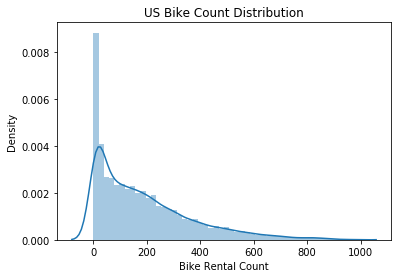

In [65]:
# First we can see the distribution of 'cnt' in US bike dataset

sns.distplot(df_full_us['cnt']).set(title='US Bike Count Distribution', xlabel='Bike Rental Count', ylabel='Density')

In [66]:
df_full_us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 11 columns):
season          17379 non-null category
hr              17379 non-null category
holiday         17379 non-null category
temp            17379 non-null float64
hum             17379 non-null float64
windspeed       17379 non-null float64
cnt             17379 non-null int64
dewPointTemp    17379 non-null float64
rainfall        17379 non-null float64
snowfall        17379 non-null float64
visibility      17379 non-null float64
dtypes: category(3), float64(7), int64(1)
memory usage: 1.2 MB


We can see that the bike rental count is centralised on 0, and it may because the data is recorded hourly.

Then we can check the relation between 'cnt' and other numerical variables!

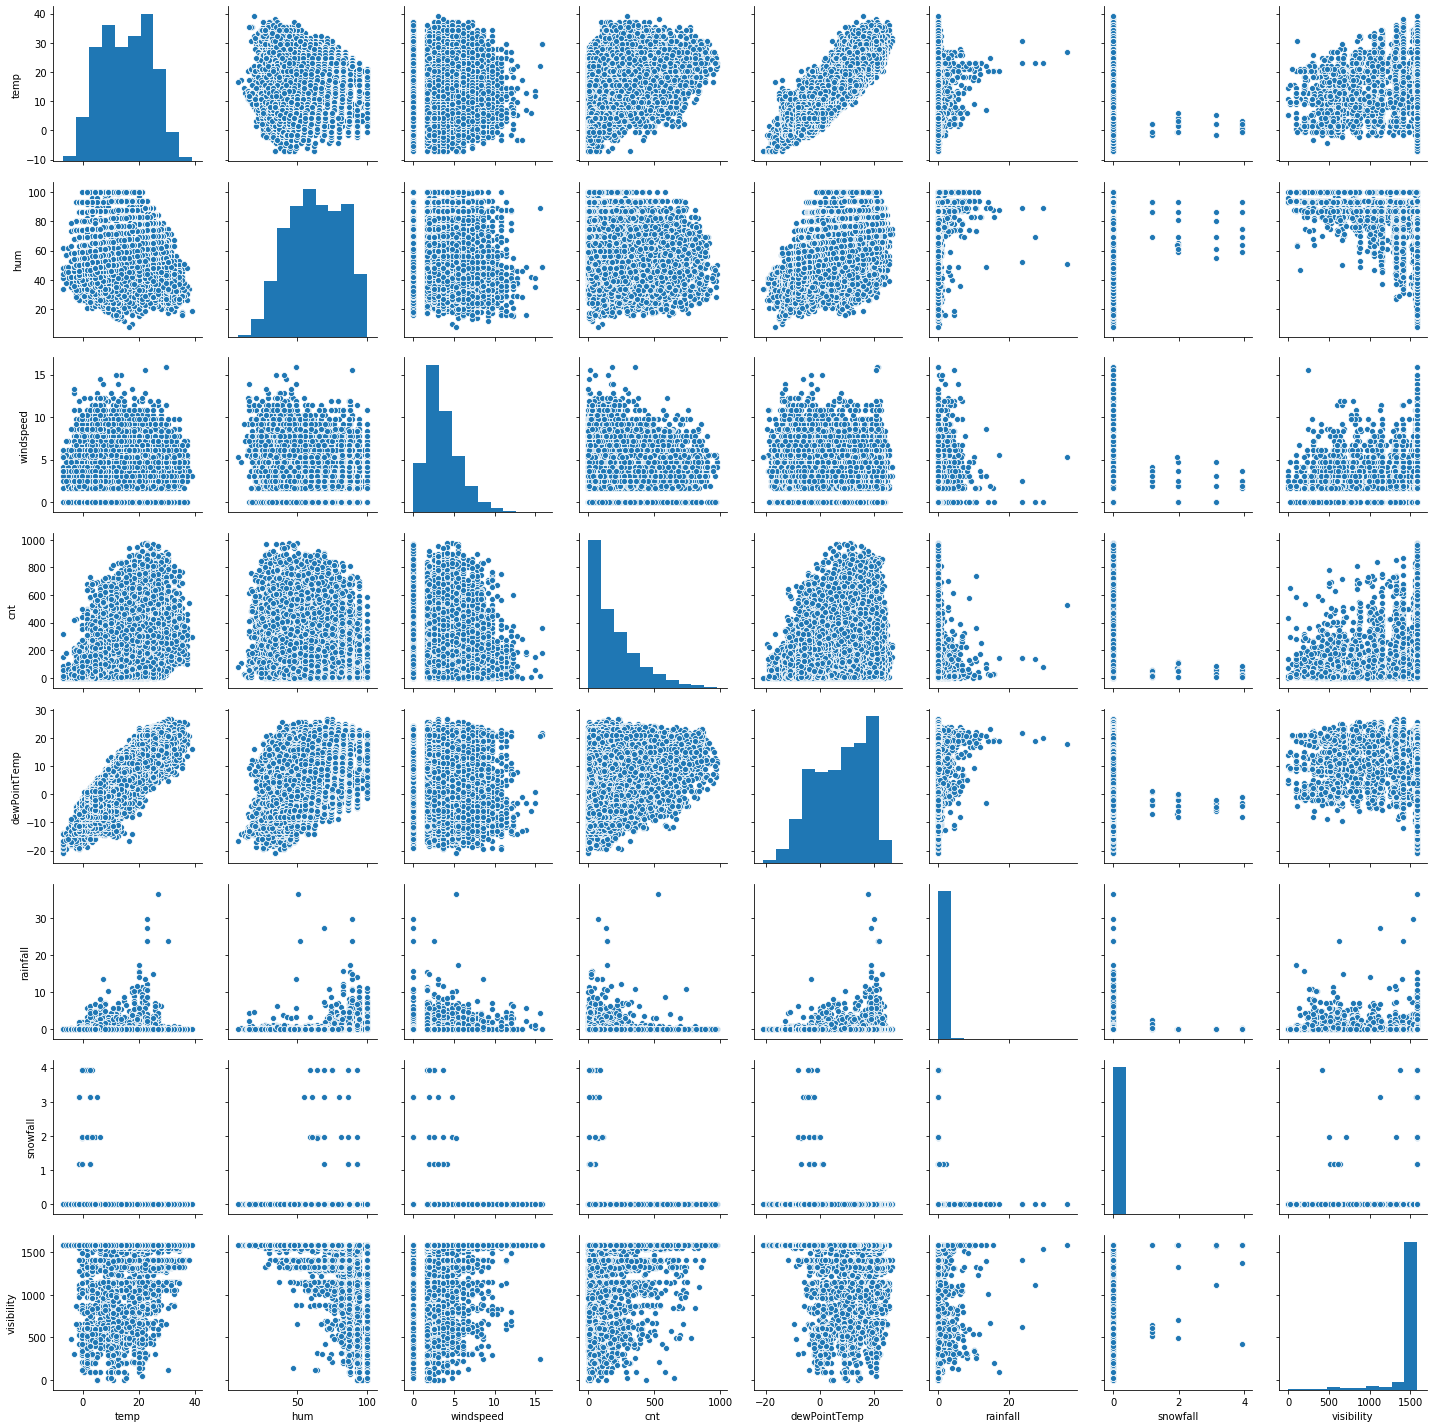

In [67]:
# scatter matrix
sns.pairplot(df_full_us.drop(['season', 'hr', 'holiday'], axis = 1)) 
plt.show()
#sns.pairplot(df_full_us, hue="species")

It seems that Wind speed, temp, dew point temp, precipitation, and visibility are more likely to have relationship between counts. 
Let's see the correlation between count and all numerical variables.

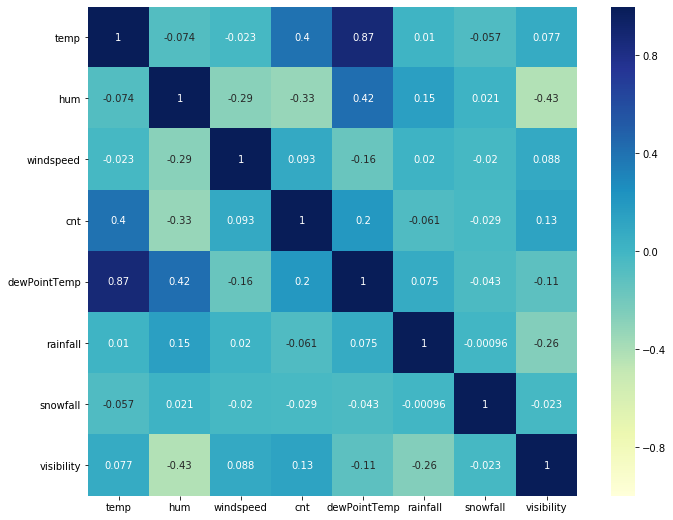

In [68]:
## correlation heatmap

#correlation matrix
corrmat = df_full_us.corr()
f, ax = plt.subplots(figsize=(12, 9))

# Loop over data dimensions and create text annotations.
sns.heatmap(corrmat,vmin = -1, vmax=1, square=True, annot=True, cmap="YlGnBu");



##### Categorical variable() vs cnt
season, yr, mnth, hr, holiday, weekday, workingday, weathersit

[Text(0, 0.5, 'Bike Rental Counts'),
 Text(0.5, 0, 'Holiday'),
 Text(0.5, 1.0, 'Boxplot of Holiday and Bike Rental Counts')]

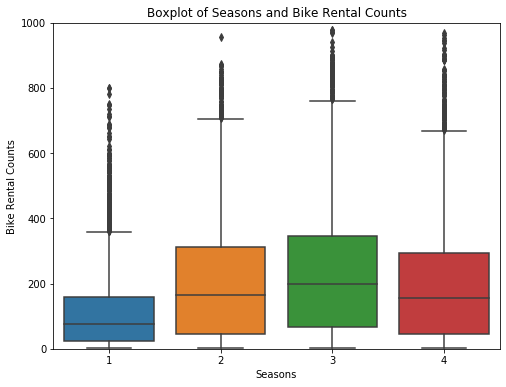

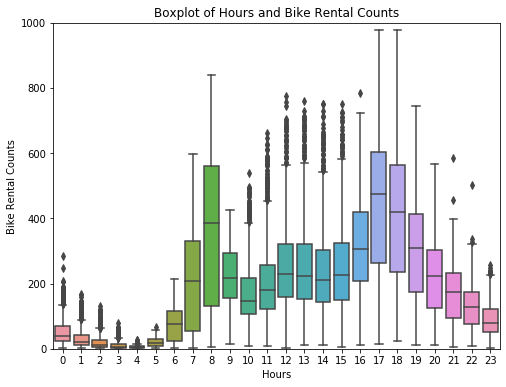

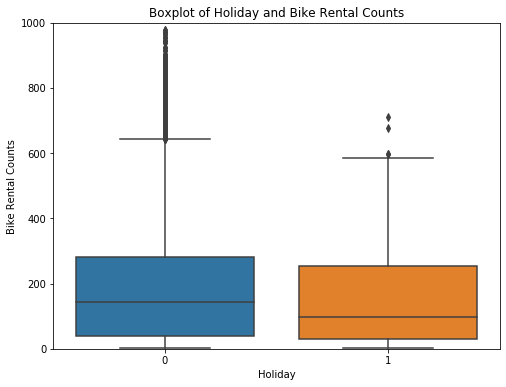

In [69]:
# box plot for categorical variable
var = 'season'
data = pd.concat([df_full_us['cnt'], df_full_us[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="cnt", data=data)
fig.axis(ymin=0, ymax=1000);
ax.set(xlabel = 'Seasons', ylabel = 'Bike Rental Counts', title = 'Boxplot of Seasons and Bike Rental Counts')

var = 'hr'
data = pd.concat([df_full_us['cnt'], df_full_us[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="cnt", data=data)
fig.axis(ymin=0, ymax=1000);
ax.set(xlabel = 'Hours', ylabel = 'Bike Rental Counts', title = 'Boxplot of Hours and Bike Rental Counts')

var = 'holiday'
data = pd.concat([df_full_us['cnt'], df_full_us[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="cnt", data=data)
fig.axis(ymin=0, ymax=1000);
ax.set(xlabel = 'Holiday', ylabel = 'Bike Rental Counts', title = 'Boxplot of Holiday and Bike Rental Counts')




- season : season (1:springer, 2:summer, 3:fall, 4:winter)
People are likely to rent bikes in Fall but less likely to rent in spring.

- hr : hour (0 to 23)
much more in 8, 17, and 18.

- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
a little more bike rentals on not holiday 


* Seoul bike data exploration

In [70]:
print(df_hour_seoul.columns)

Index(['cnt', 'hr', 'temp', 'hum', 'windspeed', 'visibility', 'dewPointTemp',
       'rainfall', 'snowfall', 'season', 'holiday'],
      dtype='object', name=0)


[Text(0, 0.5, 'Density'),
 Text(0.5, 0, 'Bike Rental Count'),
 Text(0.5, 1.0, 'Seoul Bike Count Distribution')]

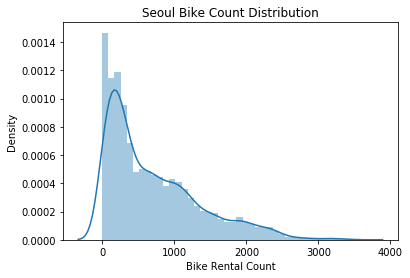

In [71]:
# First we can see the distribution of 'cnt' in seoul bike dataset

sns.distplot(df_hour_seoul['cnt']).set(title='Seoul Bike Count Distribution', xlabel='Bike Rental Count', ylabel='Density')

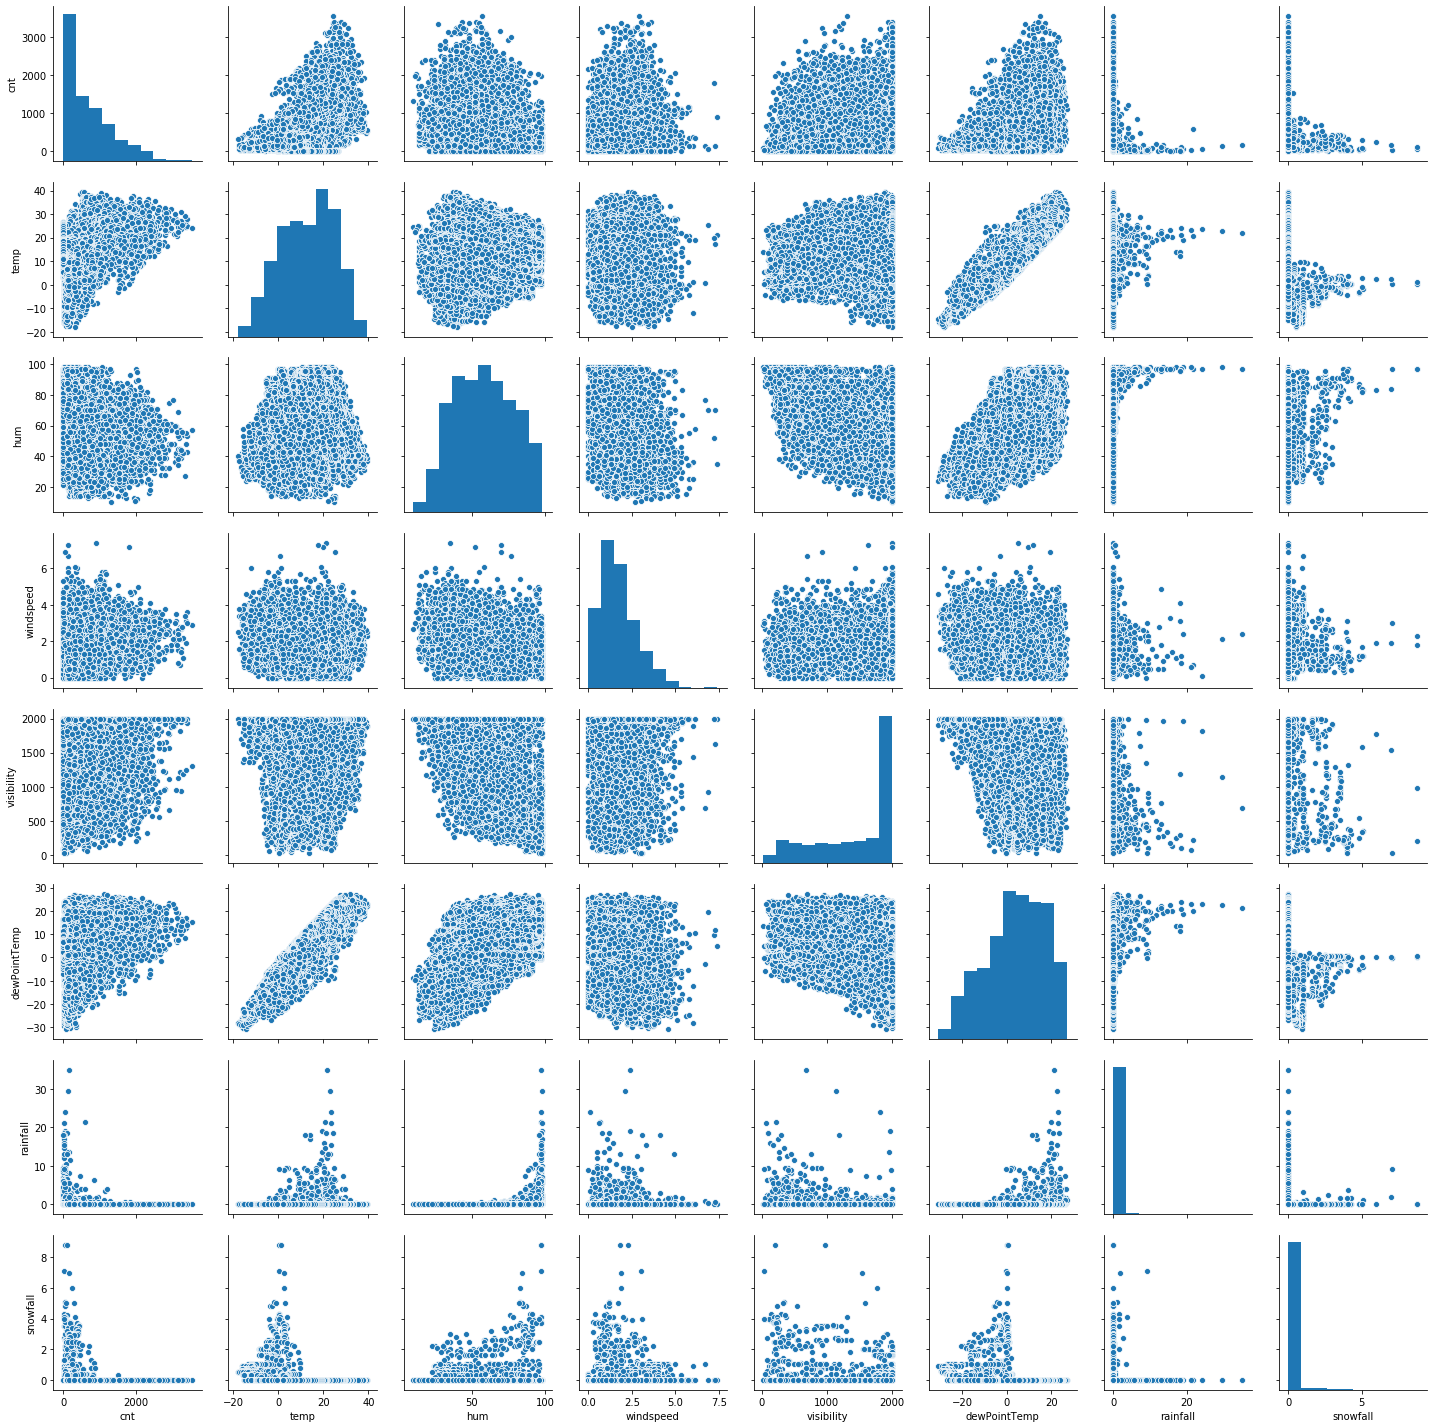

In [72]:
# scatter matrix
sns.pairplot(df_hour_seoul.drop(['season', 'hr', 'holiday'], axis = 1)) 
plt.show()
#sns.pairplot(df_full_us, hue="species")

We can see that the bike rental count is centralised on about 200, and it may because the data is recorded hourly.

Then we can check the relation between 'Rented Bike Count' and other numerical variables!

It seems that Wind speed, temperature, dew point temperature are more likely to have relationship between counts. 
Let's see the correlation between count and all numerical variables.

In [73]:
df_hour_seoul.corr()

0                  cnt      temp       hum  windspeed  visibility  \
0                                                                   
cnt           1.000000  0.538558 -0.203968   0.121108    0.199280   
temp          0.538558  1.000000  0.161525  -0.036252    0.034794   
hum          -0.203968  0.161525  1.000000  -0.344236   -0.545149   
windspeed     0.121108 -0.036252 -0.344236   1.000000    0.171507   
visibility    0.199280  0.034794 -0.545149   0.171507    1.000000   
dewPointTemp  0.379788  0.912798  0.541640  -0.176486   -0.176630   
rainfall     -0.123074  0.050282  0.237560  -0.019674   -0.167629   
snowfall     -0.141804 -0.218405  0.108090  -0.003554   -0.121695   

0             dewPointTemp  rainfall  snowfall  
0                                               
cnt               0.379788 -0.123074 -0.141804  
temp              0.912798  0.050282 -0.218405  
hum               0.541640  0.237560  0.108090  
windspeed        -0.176486 -0.019674 -0.003554  
visibility       -0.176630 -0.167629 -0.121695  
dewPointTemp      1.000000  0.125597 -0.150887  
rainfall          0.125597  1.000000  0.008500  
snowfall         -0.150887  0.008500  1.000000

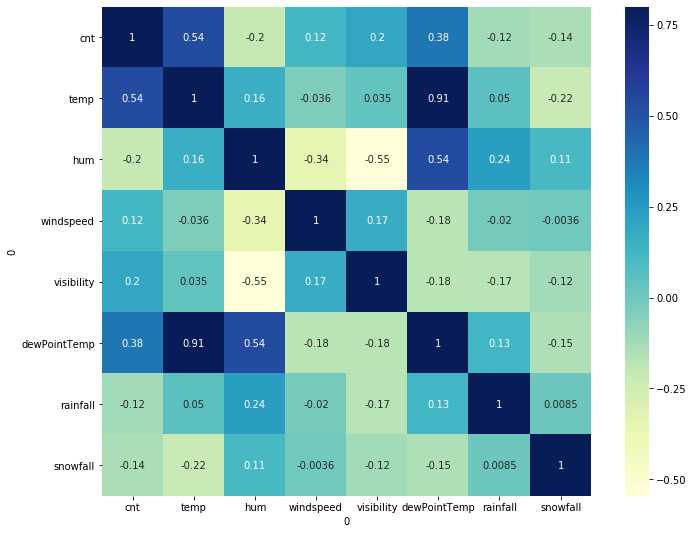

In [74]:
## correlation heatmap

corrmat = df_hour_seoul.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap="YlGnBu");



##### Categorical variable() vs cnt
'Hour', 'Seasons', 'Holiday'

[Text(0, 0.5, 'Bike Rental Counts'),
 Text(0.5, 0, 'Holiday'),
 Text(0.5, 1.0, 'Boxplot of Holiday and Bike Rental Counts')]

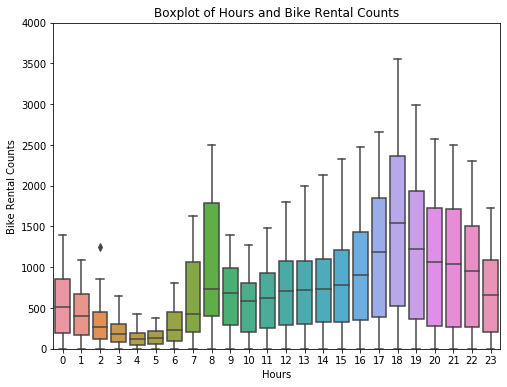

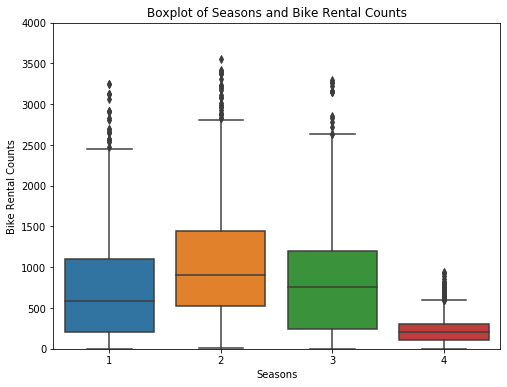

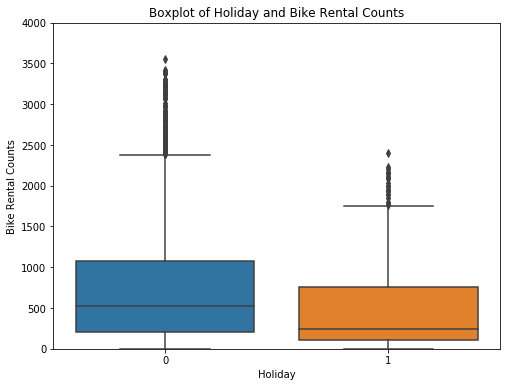

In [75]:
# box plot for categorical variable
var = 'hr'
data = pd.concat([df_hour_seoul['cnt'], df_hour_seoul[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='cnt', data=data)
fig.axis(ymin=0, ymax=4000)
ax.set(xlabel = 'Hours', ylabel = 'Bike Rental Counts', title = 'Boxplot of Hours and Bike Rental Counts')

var = 'season'
data = pd.concat([df_hour_seoul['cnt'], df_hour_seoul[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='cnt', data=data)
fig.axis(ymin=0, ymax=4000);
ax.set(xlabel = 'Seasons', ylabel = 'Bike Rental Counts', title = 'Boxplot of Seasons and Bike Rental Counts')


var = 'holiday'
data = pd.concat([df_hour_seoul['cnt'], df_hour_seoul[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='cnt', data=data)
fig.axis(ymin=0, ymax=4000);
ax.set(xlabel = 'Holiday', ylabel = 'Bike Rental Counts', title = 'Boxplot of Holiday and Bike Rental Counts')



As temperature and Dew Point temperature are in high correlation (more than 0.85) in the two datasets, they will be dropped. All other variables will be used to build models.

In [76]:
# for combined data exporation
df_full_us1 = df_full_us.copy()
df_hour_seoul1 = df_hour_seoul.copy()

In [77]:
# drop Dew Point temperature as it has high correlation with temperature
df_full_us.drop('dewPointTemp', axis = 1, inplace = True)
df_hour_seoul.drop('dewPointTemp', axis = 1, inplace = True)

In [78]:
print(df_full_us.columns)
print(df_hour_seoul.columns)

Index(['season', 'hr', 'holiday', 'temp', 'hum', 'windspeed', 'cnt',
       'rainfall', 'snowfall', 'visibility'],
      dtype='object')
Index(['cnt', 'hr', 'temp', 'hum', 'windspeed', 'visibility', 'rainfall',
       'snowfall', 'season', 'holiday'],
      dtype='object', name=0)


* Combined data before normalisation

In [79]:
df_combine_gen = pd.concat([df_full_us1, df_hour_seoul1])

/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


[Text(0, 0.5, 'Density'),
 Text(0.5, 0, 'Bike Rental Count'),
 Text(0.5, 1.0, 'Combined Count Distribution')]

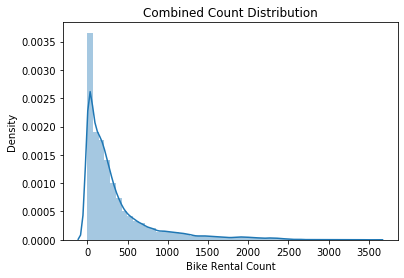

In [80]:
# First we can see the distribution of 'cnt' in the combined dataset

sns.distplot(df_combine_gen['cnt']).set(title='Combined Count Distribution', xlabel='Bike Rental Count', ylabel='Density')

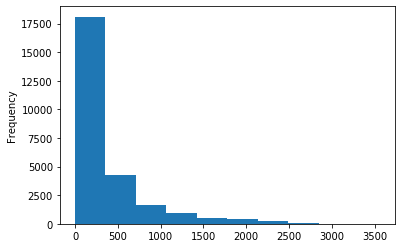

In [81]:
df_combine_gen.cnt.plot.hist()

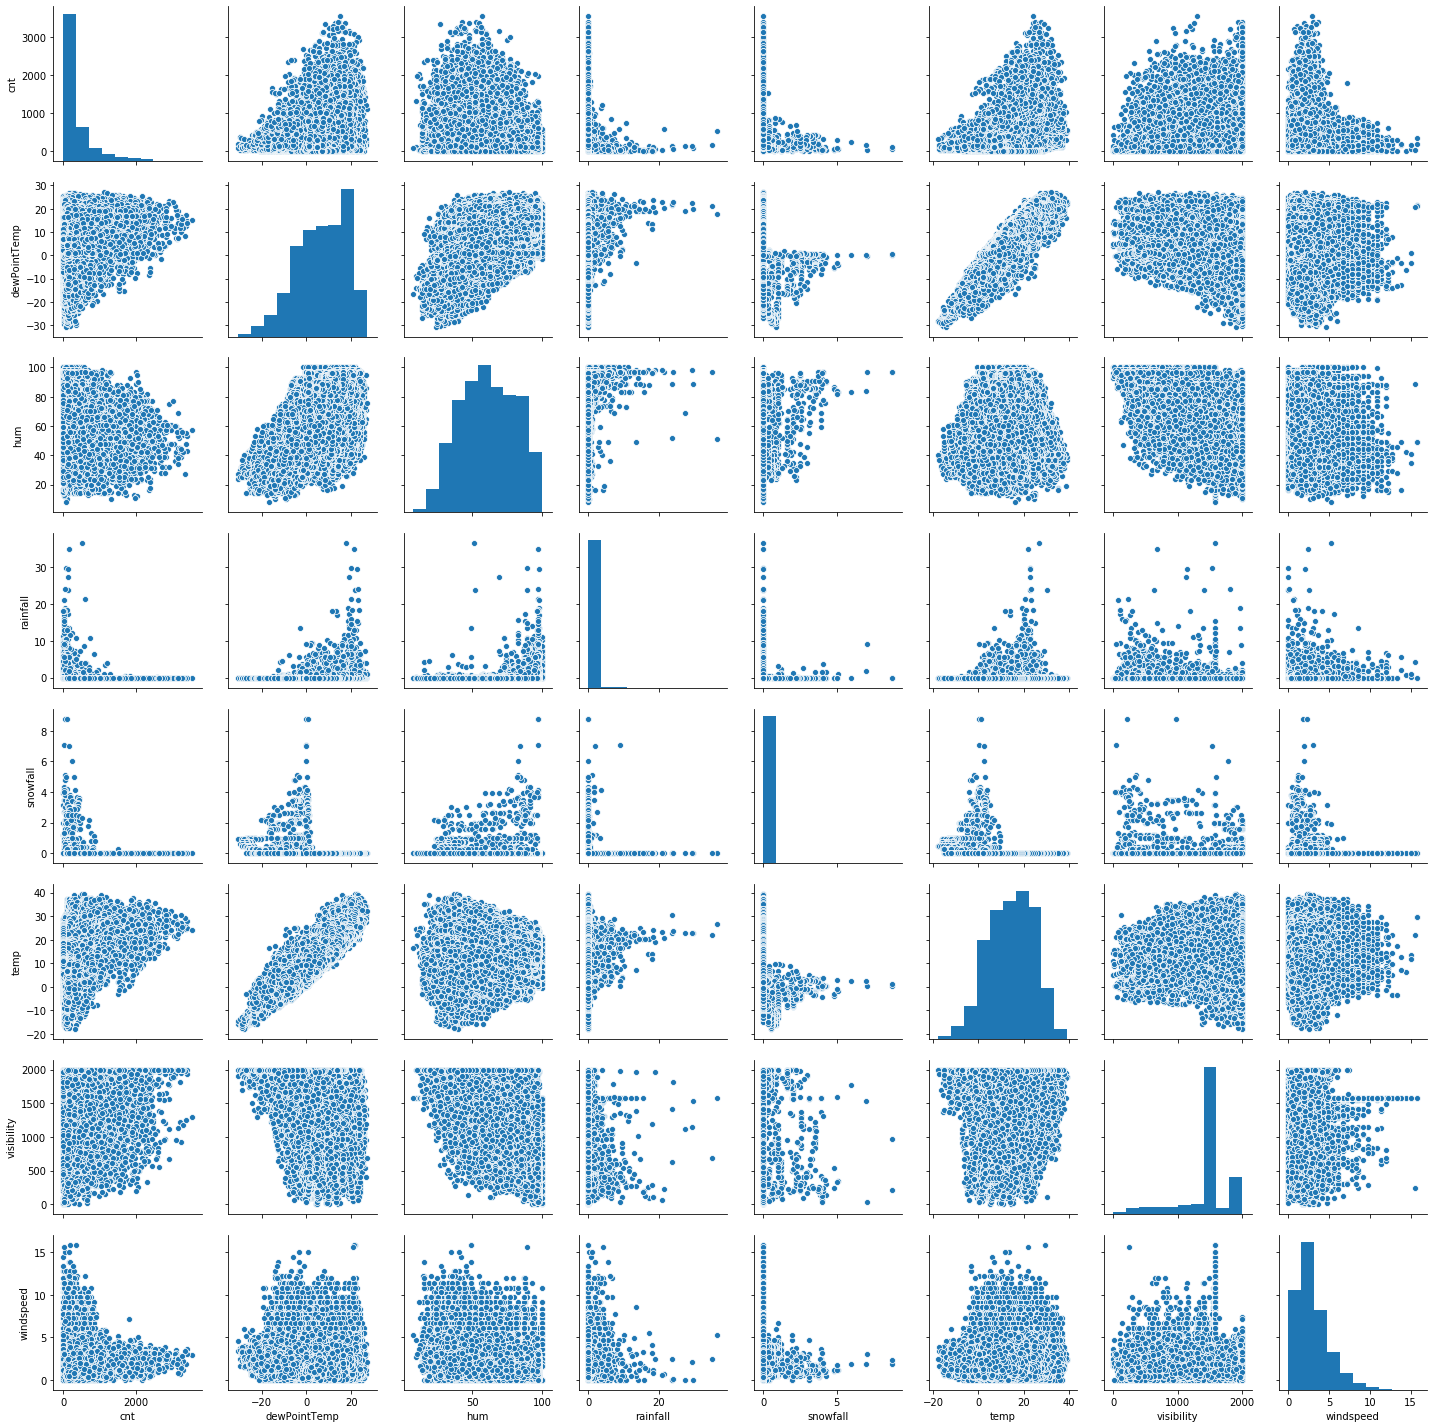

In [82]:
# scatter matrix
sns.pairplot(df_combine_gen.drop(['season', 'hr', 'holiday'], axis = 1)) 
plt.show()
#sns.pairplot(df_full_us, hue="species")

In [83]:
df_combine_gen.corr()

cnt  dewPointTemp       hum  rainfall  snowfall      temp  \
cnt           1.000000      0.162365 -0.235394 -0.071253 -0.044189  0.323905   
dewPointTemp  0.162365      1.000000  0.473761  0.094277 -0.126021  0.889583   
hum          -0.235394      0.473761  1.000000  0.181628  0.052231  0.035059   
rainfall     -0.071253      0.094277  0.181628  1.000000  0.008004  0.026636   
snowfall     -0.044189     -0.126021  0.052231  0.008004  1.000000 -0.166750   
temp          0.323905      0.889583  0.035059  0.026636 -0.166750  1.000000   
visibility    0.117833     -0.130850 -0.440120 -0.194202 -0.112220  0.056424   
windspeed    -0.155345     -0.068447 -0.213811  0.000252 -0.056714  0.024569   

              visibility  windspeed  
cnt             0.117833  -0.155345  
dewPointTemp   -0.130850  -0.068447  
hum            -0.440120  -0.213811  
rainfall       -0.194202   0.000252  
snowfall       -0.112220  -0.056714  
temp            0.056424   0.024569  
visibility      1.000000   0.109884  
windspeed       0.109884   1.000000

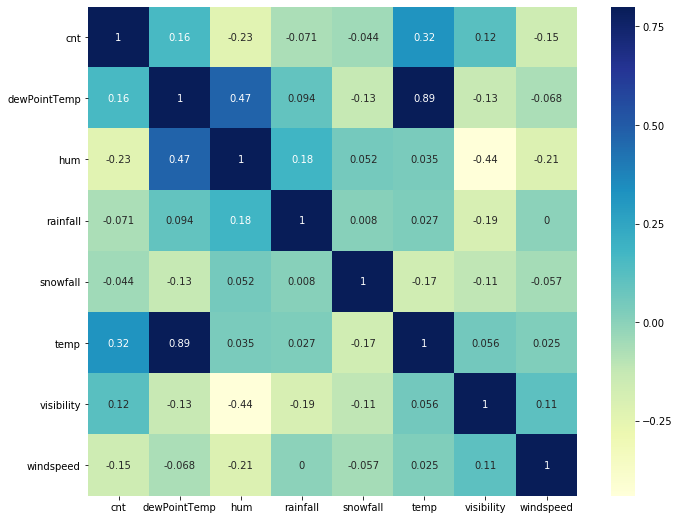

In [84]:
## correlation heatmap

corrmat = df_combine_gen.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=df_combine_gen.corr().round(3), cmap="YlGnBu")

##### Categorical variable() vs cnt
'Hour', 'Seasons', 'Holiday'

[Text(0, 0.5, 'Bike Rental Counts'),
 Text(0.5, 0, 'Holiday'),
 Text(0.5, 1.0, 'Boxplot of Holiday and Bike Rental Counts')]

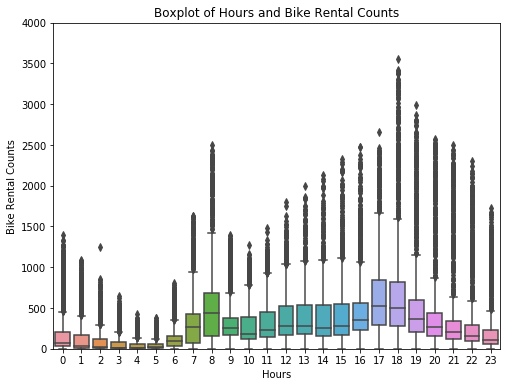

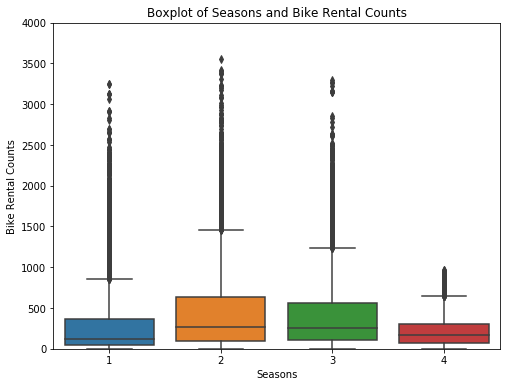

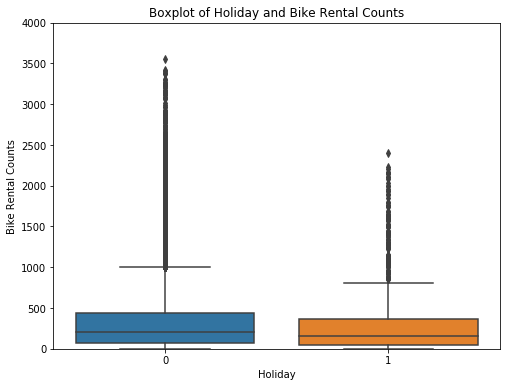

In [85]:
# box plot for categorical variable
var = 'hr'
data = pd.concat([df_combine_gen['cnt'], df_combine_gen[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='cnt', data=data)
fig.axis(ymin=0, ymax=4000)
ax.set(xlabel = 'Hours', ylabel = 'Bike Rental Counts', title = 'Boxplot of Hours and Bike Rental Counts')

var = 'season'
data = pd.concat([df_combine_gen['cnt'], df_combine_gen[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='cnt', data=data)
fig.axis(ymin=0, ymax=4000);
ax.set(xlabel = 'Seasons', ylabel = 'Bike Rental Counts', title = 'Boxplot of Seasons and Bike Rental Counts')


var = 'holiday'
data = pd.concat([df_combine_gen['cnt'], df_combine_gen[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='cnt', data=data)
fig.axis(ymin=0, ymax=4000);
ax.set(xlabel = 'Holiday', ylabel = 'Bike Rental Counts', title = 'Boxplot of Holiday and Bike Rental Counts')



In [86]:
# drop Dew Point temperature as it has high correlation with temperature
df_combine_gen.drop('dewPointTemp', axis = 1, inplace = True)

In [87]:
# dataset for next step
df_combine = df_combine_gen.copy()

In [88]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26139 entries, 2011-01-01 00:00:00 to 2018-11-30 23:00:00
Data columns (total 10 columns):
cnt           26139 non-null int64
holiday       26139 non-null category
hr            26139 non-null category
hum           26139 non-null float64
rainfall      26139 non-null float64
season        26139 non-null category
snowfall      26139 non-null float64
temp          26139 non-null float64
visibility    26139 non-null float64
windspeed     26139 non-null float64
dtypes: category(3), float64(6), int64(1)
memory usage: 1.7 MB


In [89]:
df_combine.describe()

cnt           hum      rainfall      snowfall          temp  \
count  26139.000000  26139.000000  26139.000000  26139.000000  26139.000000   
mean     362.102338     61.336646      0.120756      0.027763     14.528788   
std      469.486157     19.659245      0.932570      0.269713     10.180030   
min        0.000000      8.000000      0.000000      0.000000    -17.800000   
25%       67.000000     46.000000      0.000000      0.000000      7.040000   
50%      201.000000     61.000000      0.000000      0.000000     15.500000   
75%      436.000000     77.000000      0.000000      0.000000     22.700000   
max     3556.000000    100.000000     36.576000      8.800000     39.400000   

         visibility     windspeed  
count  26139.000000  26139.000000  
mean    1480.279200      2.930330  
std      405.436366      2.130512  
min        0.000000      0.000000  
25%     1552.000000      1.500000  
50%     1584.000000      2.499474  
75%     1584.000000      4.167031  
max     2000.000000     15.832485

In [90]:
df_combine.head()

cnt holiday hr   hum  rainfall season  snowfall  temp  \
2011-01-01 00:00:00   16       0  0  81.0       0.0      1       0.0  3.28   
2011-01-01 01:00:00   40       0  1  80.0       0.0      1       0.0  2.34   
2011-01-01 02:00:00   32       0  2  80.0       0.0      1       0.0  2.34   
2011-01-01 03:00:00   13       0  3  75.0       0.0      1       0.0  3.28   
2011-01-01 04:00:00    1       0  4  75.0       0.0      1       0.0  3.28   

                     visibility  windspeed  
2011-01-01 00:00:00      1584.0        0.0  
2011-01-01 01:00:00      1408.0        0.0  
2011-01-01 02:00:00      1328.0        0.0  
2011-01-01 03:00:00      1328.0        0.0  
2011-01-01 04:00:00      1328.0        0.0

In [91]:
df_combine.corr()

cnt       hum  rainfall  snowfall      temp  visibility  \
cnt         1.000000 -0.235394 -0.071253 -0.044189  0.323905    0.117833   
hum        -0.235394  1.000000  0.181628  0.052231  0.035059   -0.440120   
rainfall   -0.071253  0.181628  1.000000  0.008004  0.026636   -0.194202   
snowfall   -0.044189  0.052231  0.008004  1.000000 -0.166750   -0.112220   
temp        0.323905  0.035059  0.026636 -0.166750  1.000000    0.056424   
visibility  0.117833 -0.440120 -0.194202 -0.112220  0.056424    1.000000   
windspeed  -0.155345 -0.213811  0.000252 -0.056714  0.024569    0.109884   

            windspeed  
cnt         -0.155345  
hum         -0.213811  
rainfall     0.000252  
snowfall    -0.056714  
temp         0.024569  
visibility   0.109884  
windspeed    1.000000

#### Mutual Information Calculation

Choose feature sets to apply interaction term

* Combined data

In [92]:
df_toBin = df_combine.drop('cnt', axis = 1).select_dtypes(include = [np.number])
#df_toBin

In [93]:
# bin numerical data
cut_labels_4 = ['0', '1', '2', '3']
bins = [-np.inf, 0.01, 0.12, 0.5, np.inf]
bins_v = [-np.inf, 700, 1200, 1800, np.inf]
df_binned = df_toBin.copy()

for col in df_toBin:
    print(col)
    if col in ['rainfall', 'snowfall']:
        df_binned[col] = pd.cut(df_toBin[col], bins=bins, labels=cut_labels_4)
        print(df_binned[col].value_counts())
    elif col in ['visibility']:
        df_binned[col] = pd.cut(df_toBin[col], bins=bins_v, labels=cut_labels_4)
        print(df_binned[col].value_counts())
    else:
        df_binned[col] = pd.qcut(df_toBin[col], q=4, labels=cut_labels_4)
        print(df_binned[col].value_counts())
    print('-------------')

hum
0    6821
3    6487
1    6428
2    6403
Name: hum, dtype: int64
-------------
rainfall
0    24464
3     1103
2      526
1       46
Name: rainfall, dtype: int64
-------------
snowfall
0    25669
3      356
2      112
1        2
Name: snowfall, dtype: int64
-------------
temp
0    7085
3    6533
1    6523
2    5998
Name: temp, dtype: int64
-------------
visibility
2    17767
3     3980
1     2198
0     2194
Name: visibility, dtype: int64
-------------
windspeed
1    7094
0    6651
2    6620
3    5774
Name: windspeed, dtype: int64
-------------


##### Data exploration to decide the bins for those columns qcut does not apply:

Text(0.5, 1.0, 'Log Value of Rainfall')

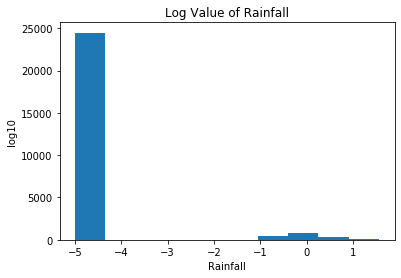

In [94]:
# rainfall
np.log10(df_combine.rainfall+0.00001).plot.hist(bins=10)
plt.xlabel('Rainfall')
plt.ylabel('log10')
plt.title('Log Value of Rainfall')

Text(0.5, 1.0, 'Log Value of Snowfall')

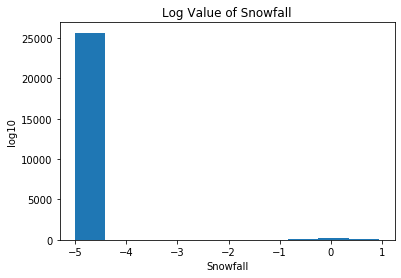

In [95]:
# snowfall
np.log10(df_combine.snowfall+0.00001).plot.hist(bins=10)
plt.xlabel('Snowfall')
plt.ylabel('log10')
plt.title('Log Value of Snowfall')

Text(0.5, 1.0, 'Log Value of Visibility')

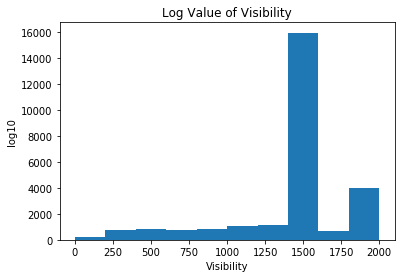

In [96]:
# visibility
df_combine.visibility.plot.hist(bins=10)
plt.xlabel('Visibility')
plt.ylabel('log10')
plt.title('Log Value of Visibility')

##### compute MI

In [97]:
df_combine_binned = df_combine.copy()

for col in df_binned:
    df_combine_binned[col] = df_binned[col]

In [98]:
# MI dataframe

from sklearn.metrics.cluster import normalized_mutual_info_score

df_MI = pd.DataFrame(None, index = df_combine_binned.columns, 
                           columns = df_combine_binned.columns)

for i, col_i in enumerate(df_MI.columns):
    for j, col_j in enumerate(df_MI.columns):
        if i <= j:
            df_MI.loc[col_i, col_j] = normalized_mutual_info_score(df_combine_binned[col_i], 
                                                                   df_combine_binned[col_j])

In [99]:
# fill 0 with na
df_toPlot = df_MI.fillna(0)
df_toPlot = (df_toPlot + df_toPlot.T)/2
for col in df_MI:
    df_toPlot.loc[col, col] = 0.

#df_toPlot

(10.5, -0.5)

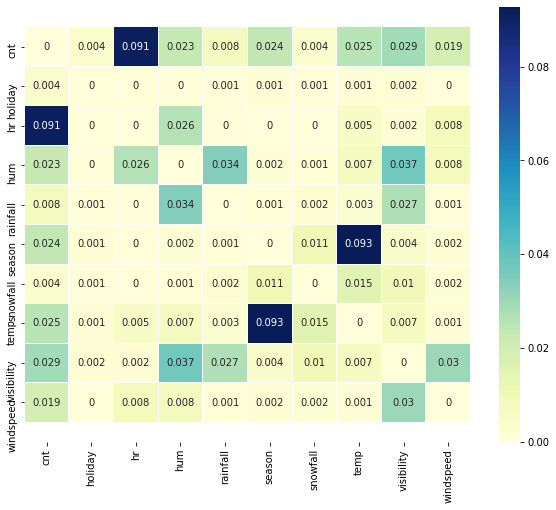

In [100]:
# MI heatmap
ax = plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_toPlot, annot=df_toPlot.round(3), linewidths = 0.02, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

* Korean data

In [101]:
df_toBin = df_hour_seoul.drop('cnt', axis = 1).select_dtypes(include = [np.number])
#df_toBin

In [102]:
# bin the category data

cut_labels_4 = ['0', '1', '2', '3']
bins = [-np.inf, 0.01, 0.5, 1, np.inf]
bins_v = [-np.inf, 700, 1200, 1800, np.inf]
df_binned = df_toBin.copy()

for col in df_toBin:
    print(col)
    if col in ['rainfall', 'snowfall']:
        df_binned[col] = pd.cut(df_toBin[col], bins=bins, labels=cut_labels_4)
        print(df_binned[col].value_counts())
    elif col in ['visibility']:
        df_binned[col] = pd.cut(df_toBin[col], bins=bins_v, labels=cut_labels_4)
        print(df_binned[col].value_counts())
    else:
        df_binned[col] = pd.qcut(df_toBin[col], q=4, labels=cut_labels_4)
        print(df_binned[col].value_counts())
    print('-------------')

temp
0    2216
2    2195
3    2182
1    2167
Name: temp, dtype: int64
-------------
hum
0    2344
2    2211
3    2140
1    2065
Name: hum, dtype: int64
-------------
windspeed
1    2253
0    2218
3    2168
2    2121
Name: windspeed, dtype: int64
-------------
visibility
3    3980
2    1867
0    1593
1    1320
Name: visibility, dtype: int64
-------------
rainfall
0    8232
3     248
1     207
2      73
Name: rainfall, dtype: int64
-------------
snowfall
0    8317
3     188
2     141
1     114
Name: snowfall, dtype: int64
-------------


##### Data exploration to decide the bins for those columns qcut does not apply:

Text(0.5, 1.0, 'Log Value of Rainfall')

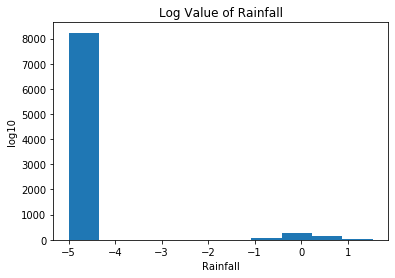

In [103]:
# rainfall
np.log10(df_hour_seoul.rainfall+0.00001).plot.hist(bins=10)
plt.xlabel('Rainfall')
plt.ylabel('log10')
plt.title('Log Value of Rainfall')

Text(0.5, 1.0, 'Log Value of Snowfall')

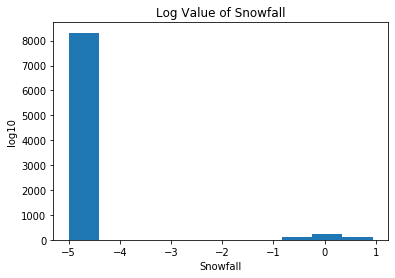

In [104]:
# snowfall
np.log10(df_hour_seoul.snowfall+0.00001).plot.hist(bins=10)
plt.xlabel('Snowfall')
plt.ylabel('log10')
plt.title('Log Value of Snowfall')

Text(0.5, 1.0, 'Log Value of Visibility')

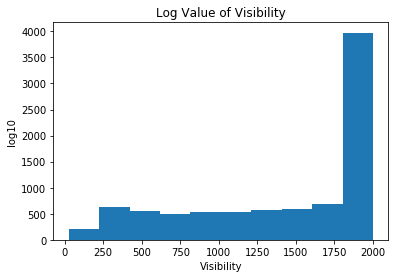

In [105]:
# visibility
df_hour_seoul.visibility.plot.hist(bins=10)
plt.xlabel('Visibility')
plt.ylabel('log10')
plt.title('Log Value of Visibility') 

##### compute MI

In [106]:
df_seoul_binned = df_hour_seoul.copy()

for col in df_binned:
    df_seoul_binned[col] = df_binned[col]

In [107]:
# create a MI dataframe
df_MI = pd.DataFrame(None, index = df_seoul_binned.columns, 
                           columns = df_seoul_binned.columns)

for i, col_i in enumerate(df_MI.columns):
    for j, col_j in enumerate(df_MI.columns):
        if i <= j:
            df_MI.loc[col_i, col_j] = normalized_mutual_info_score(df_seoul_binned[col_i], 
                                                                   df_seoul_binned[col_j])

In [108]:
df_toPlot = df_MI.fillna(0)
df_toPlot = (df_toPlot + df_toPlot.T)/2
for col in df_MI:
    df_toPlot.loc[col, col] = 0.

#df_toPlot

(10.5, -0.5)

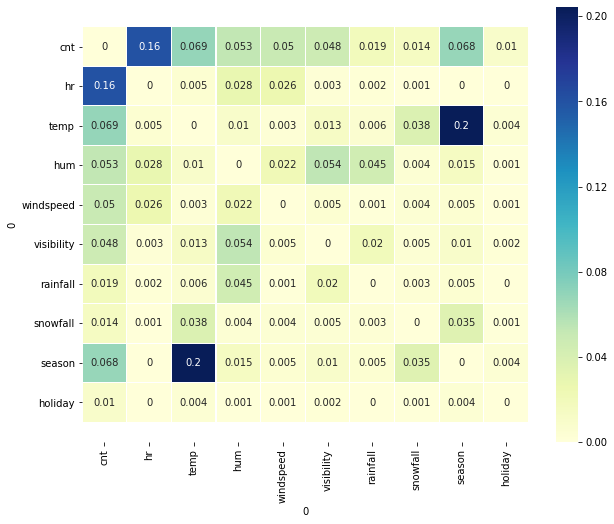

In [109]:
# MI heatmap
ax = plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_toPlot, annot=df_toPlot.round(3), linewidths = 0.02, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

##### split data and data standardisation

test data is fixed to the last 30% in Korean data

For Mix model:
* train: the whole US dataset and the first 70% of Korean data

For Korean model:
* train: the first 70% of KR dataset 

----------
The US dataset and KR dataset are normalised and add 1 categorical variable in X variables.

In [110]:
# KR data: normalisation and data split
X_kr = df_hour_seoul.drop('cnt', axis = 1)
Y_kr = df_hour_seoul['cnt']
split_kr = len(df_hour_seoul)

## Randomly choose KR data for train and test set

# create a random list of index
random_list = list(range(split_kr))
random.Random(42).shuffle(random_list)
train_index = random_list[:int(len(random_list)*0.7)]
test_index = random_list[int(len(random_list)*0.7):]
#print(random)

## normalisation

# X normalisation
X_min_kr = X_kr.iloc[:, 1:7].min()
X_max_kr = X_kr.iloc[:, 1:7].max()
X_kr.iloc[:, 1:7] = (X_kr.iloc[:, 1:7] - X_min_kr)/(X_max_kr-X_min_kr)

# add a category variable
X_kr['add'] = 0
X_kr['add'] = X_kr['add'].astype('category')

## data split

# train set
X_train_kr = X_kr.iloc[train_index, :]
Y_train_kr = Y_kr.iloc[train_index]

# test set 
X_test = X_kr.iloc[test_index, :]
Y_test = Y_kr.iloc[test_index]

In [111]:
# combined data for training 

# US data: normalisation and data split
X_us = df_full_us.drop('cnt', axis = 1)
Y_us = df_full_us['cnt']

# add a category variable
X_us['add'] = 1


# combined data
X_train_combine = pd.concat([X_us, X_train_kr])
Y_train_combine = pd.concat([Y_us, Y_train_kr])


X_train_combine['add'] = X_train_combine['add'].astype('category')
#split_us = len(df_full_us)

#df_train_US = df_full_us.iloc[:int(split_us*0.7), :]
#df_test_US = df_full_us.iloc[int(split_us*0.7):, :]

## normalisation
# X normalisation
X_min_com = X_train_combine.iloc[:, 3:5].min()
X_max_com = X_train_combine.iloc[:, 3:5].max()
X_train_combine.iloc[:, 3:5] = (X_train_combine.iloc[:, 3:5] - X_min_com)/(X_max_com-X_min_com)

X_min_com = X_train_combine.iloc[:, 6:].min()
X_max_com = X_train_combine.iloc[:, 6:].max()
X_train_combine.iloc[:, 6:] = (X_train_combine.iloc[:, 6:] - X_min_com)/(X_max_com-X_min_com)



/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [112]:
X_train_combine.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23511 entries, 2011-01-01 00:00:00 to 2017-12-11 18:00:00
Data columns (total 10 columns):
add           23511 non-null category
holiday       23511 non-null category
hr            23511 non-null category
hum           23511 non-null float64
rainfall      23511 non-null float64
season        23511 non-null category
snowfall      23511 non-null float64
temp          23511 non-null float64
visibility    23511 non-null float64
windspeed     23511 non-null float64
dtypes: category(4), float64(6)
memory usage: 1.3 MB


In [113]:
X_train_kr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6132 entries, 2018-05-26 18:00:00 to 2017-12-11 18:00:00
Data columns (total 10 columns):
hr            6132 non-null category
temp          6132 non-null float64
hum           6132 non-null float64
windspeed     6132 non-null float64
visibility    6132 non-null float64
rainfall      6132 non-null float64
snowfall      6132 non-null float64
season        6132 non-null category
holiday       6132 non-null category
add           6132 non-null category
dtypes: category(4), float64(6)
memory usage: 360.5 KB


In [114]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2628 entries, 2018-02-21 16:00:00 to 2018-02-15 00:00:00
Data columns (total 10 columns):
hr            2628 non-null category
temp          2628 non-null float64
hum           2628 non-null float64
windspeed     2628 non-null float64
visibility    2628 non-null float64
rainfall      2628 non-null float64
snowfall      2628 non-null float64
season        2628 non-null category
holiday       2628 non-null category
add           2628 non-null category
dtypes: category(4), float64(6)
memory usage: 155.2 KB


In [115]:
print('Combined Train Data')
X_train_combine.describe()

Combined Train Data


hum      rainfall      snowfall          temp    visibility  \
count  23511.000000  23511.000000  23511.000000  23511.000000  23511.000000   
mean       0.465990      0.002186      0.001337      0.402784      0.701123   
std        0.319519      0.019227      0.024459      0.220253      0.436694   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.009659      0.000000      0.000000      0.169751      0.000631   
50%        0.520000      0.000000      0.000000      0.367347      1.000000   
75%        0.730000      0.000000      0.000000      0.591837      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          windspeed  
count  23511.000000  
mean       0.169022  
std        0.153972  
min        0.000000  
25%        0.015364  
50%        0.157870  
75%        0.263195  
max        1.000000

In [116]:
print('KR Train Data')
X_train_kr.describe()

KR Train Data


0             temp          hum    windspeed   visibility     rainfall  \
count  6132.000000  6132.000000  6132.000000  6132.000000  6132.000000   
mean      0.534994     0.548720     0.233313     0.714601     0.004191   
std       0.209988     0.229365     0.141231     0.308254     0.031569   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.365385     0.363636     0.121622     0.463254     0.000000   
50%       0.548951     0.534091     0.202703     0.845666     0.000000   
75%       0.706294     0.727273     0.310811     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     0.842857   

0         snowfall  
count  6132.000000  
mean      0.009095  
std       0.052710  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [117]:
print('-------------')
print('Test Data')
Y_test.describe()
X_test.describe()

-------------
Test Data


0             temp          hum    windspeed   visibility     rainfall  \
count  2628.000000  2628.000000  2628.000000  2628.000000  2628.000000   
mean      0.539729     0.550694     0.232589     0.714463     0.004381   
std       0.206089     0.230000     0.137249     0.308503     0.033740   
min       0.024476     0.034091     0.000000     0.005575     0.000000   
25%       0.381119     0.375000     0.135135     0.460720     0.000000   
50%       0.555944     0.534091     0.202703     0.849214     0.000000   
75%       0.704545     0.727273     0.310811     1.000000     0.000000   
max       0.973776     1.000000     0.932432     1.000000     1.000000   

0         snowfall  
count  2628.000000  
mean      0.007213  
std       0.041544  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       0.579545

In [118]:
print('Combined Train Data')
print(len(Y_train_combine))
print(len(X_train_combine))

print('-------------')
print('KR Train Data')
#print(len(df_hour_seoul))
print(len(Y_train_kr))
print(len(X_train_kr))

print('-------------')
print('Test Data')
print(len(Y_test))
print(len(X_test))

Combined Train Data
23511
23511
-------------
KR Train Data
6132
6132
-------------
Test Data
2628
2628


### Model Construction
1. Poisson GLM
2. NB GLM

#### 1. Poisson GLM
##### Model with interaction with combined data

In [119]:
## add constant in X
X_train_combine = sm.add_constant(X_train_combine, prepend=False)
X_test = sm.add_constant(X_test, prepend=False)

/Users/demi/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [120]:
## set formula

formula_glm = 'cnt ~ C(season)+C(hr)+C(holiday)+C(add)+temp+hum+windspeed+rainfall+snowfall+visibility+C(hr)*hum+hum*rainfall+hum*visibility+rainfall*visibility+C(season)*temp+visibility*windspeed'
formula_glm_simple = 'cnt ~ C(season)+C(hr)+C(holiday)+C(add)+temp+hum+windspeed+rainfall+snowfall+visibility'
formula_glm_kr = 'cnt ~ C(season)+C(hr)+C(holiday)+C(add)+temp+hum+windspeed+rainfall+snowfall+visibility+C(hr)*hum+C(hr)*windspeed+temp* snowfall +temp*C(season) +hum*visibility +hum* rainfall + snowfall*C(season)'
## set regularised alpha
alpha_glm=10e-5


In [121]:
# fit Poisson GLM
glm_poisson = glm(formula= formula_glm, data = X_train_combine.join(Y_train_combine), family=sm.families.Poisson())
# add L1 regularised
glm_poisson = glm_poisson.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [122]:
print(glm_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                23511
Model:                            GLM   Df Residuals:                    23446
Model Family:                 Poisson   Df Model:                           65
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -1.2340e+06
Date:                Fri, 10 Sep 2021   Deviance:                   2.3102e+06
Time:                        15:09:01   Pearson chi2:                 6.84e+06
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.1394 

In [123]:
len(glm_poisson.mu)

23511

In [124]:
#print('Parameters: ', glm_poisson.params)
#print('T-values: ', glm_poisson.tvalues)

In [125]:
# dispersion
print('data dispersion:', glm_poisson.pearson_chi2/23449)

data dispersion: 291.63433538727185


In [126]:
# confidence interval
summary_df_combine = pd.DataFrame(glm_poisson.summary2().tables[1])
confidence_combine = summary_df_combine.iloc[:,:1]

# calculate confidence interval
CI_combine = np.array([glm_poisson.params - 2 * glm_poisson.bse, glm_poisson.params + 2 * glm_poisson.bse]) # Compute 95% CI for parameters of Model 2.
confidence_combine['Low Interval'] = CI_combine[0] 
confidence_combine['High Interval'] = CI_combine[1]

# take exp
confidence_combine_exp = np.exp(confidence_combine)


/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [127]:
# for visualisation
nobs = glm_poisson.nobs
y = Y_train_combine.values
yhat = glm_poisson.mu

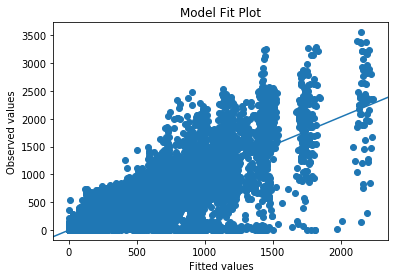

In [128]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [129]:
print(glm_poisson.mu, len(glm_poisson.mu))
print(glm_poisson.resid_pearson, len(glm_poisson.resid_pearson))

[ 32.52162962  20.91212573  14.76371897 ... 416.25182137 753.04441916
 644.23917728] 23511
[-2.89712165  4.17405796  4.48585965 ... 11.75106539 -8.05506886
 -3.43706698] 23511


Text(0.5, 0, 'Fitted values')

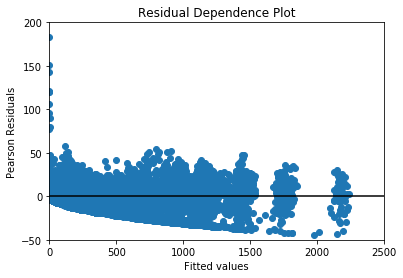

In [130]:
fig, ax = plt.subplots()
yhat = glm_poisson.mu
ax.scatter(yhat, glm_poisson.resid_pearson)
ax.hlines(0, 0, 2500)
ax.set_xlim(0, 2500)
ax.set_ylim(-50, 200)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

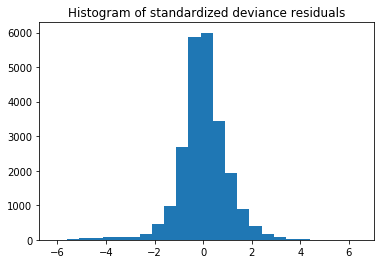

In [131]:
fig, ax = plt.subplots()

resid = glm_poisson.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

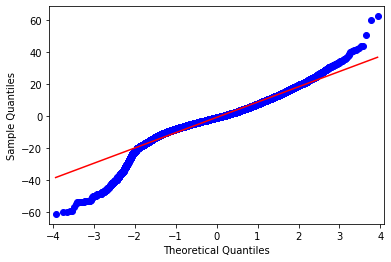

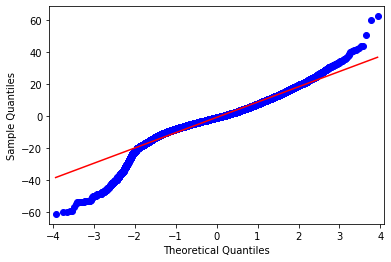

In [132]:
graphics.gofplots.qqplot(resid, line='r')

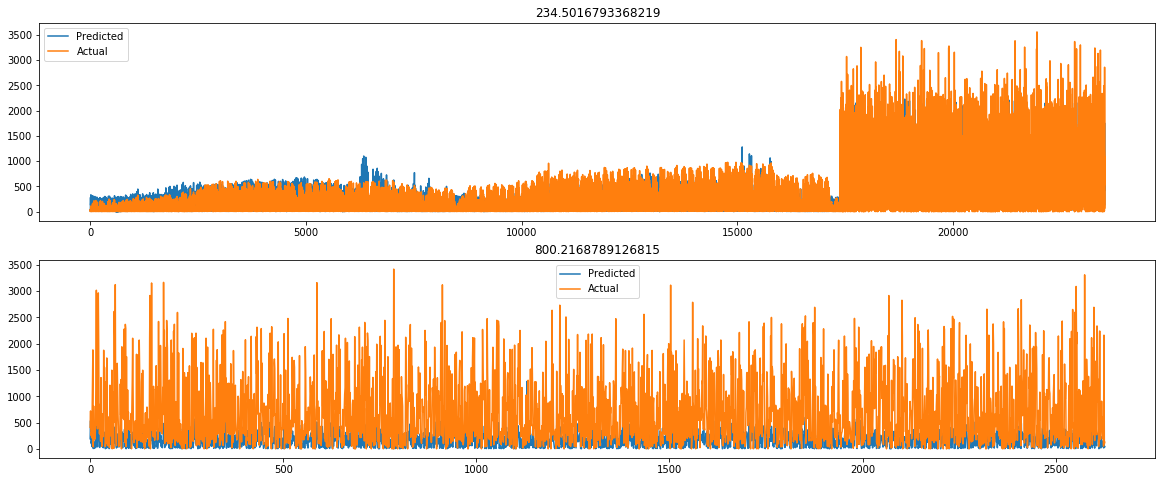

In [133]:
Y_train_pred = glm_poisson.predict(X_train_combine)
Y_test_pred = glm_poisson.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_combine)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_combine, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [134]:
print(glm_poisson.aic)
#glm_poisson.bic
print(glm_poisson.deviance)

2468060.711377389
2310168.211552079


##### Poisson GLM model without interaction with combined data 

In [135]:
## fit Poisson model
glm_poisson_simple = glm(formula= formula_glm_simple, data = X_train_combine.join(Y_train_combine), family=sm.families.Poisson())
# add regularised term
glm_poisson_simple = glm_poisson_simple.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [136]:
print(glm_poisson_simple.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                23511
Model:                            GLM   Df Residuals:                    23476
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -1.5599e+06
Date:                Fri, 10 Sep 2021   Deviance:                   2.9621e+06
Time:                        15:09:27   Pearson chi2:                 3.21e+07
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.8241      0.002   23

In [137]:
# confidence interval
summary_df_combine_simple = pd.DataFrame(glm_poisson_simple.summary2().tables[1])
confidence_combine_simple =summary_df_combine_simple.iloc[:,:1]

# calculate confidence interval
CI_combine_simple = np.array([glm_poisson_simple.params - 2 * glm_poisson_simple.bse, glm_poisson_simple.params + 2 * glm_poisson_simple.bse]) # Compute 95% CI for parameters of Model 2.
confidence_combine_simple['Low Interval'] = CI_combine_simple[0] 
confidence_combine_simple['High Interval'] = CI_combine_simple[1]

# take exp
confidence_combine_simple_exp = np.exp(confidence_combine_simple)


/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [138]:
print('data dispersion:', glm_poisson_simple.pearson_chi2/23476)

data dispersion: 1368.7675786784166


In [139]:
# for visualisation
nobs = glm_poisson_simple.nobs
y = Y_train_combine.values#/Y_train_combine.sum()
yhat = glm_poisson_simple.mu

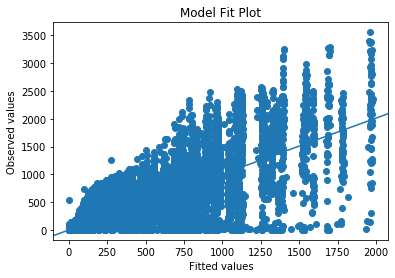

In [140]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [141]:
print(glm_poisson_simple.mu, len(glm_poisson_simple.mu))
print(glm_poisson_simple.resid_pearson, len(glm_poisson_simple.resid_pearson))

[  75.76590645   53.56263064   35.79030735 ...  277.07211584  763.93642956
 1040.98344485] 23511
[ -6.86620236  -1.85316029  -0.63356578 ...  22.76460685  -8.39151465
 -15.00059877] 23511


Text(0.5, 0, 'Fitted values')

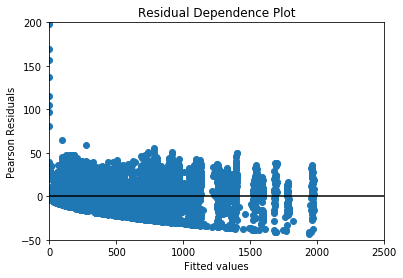

In [142]:
fig, ax = plt.subplots()
yhat = glm_poisson_simple.mu
ax.scatter(yhat, glm_poisson_simple.resid_pearson)
ax.hlines(0, 0, 2500)
ax.set_xlim(0, 2500)
ax.set_ylim(-50, 200)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

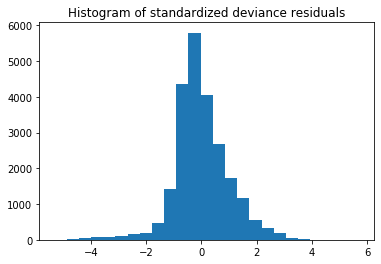

In [143]:
fig, ax = plt.subplots()

resid = glm_poisson_simple.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

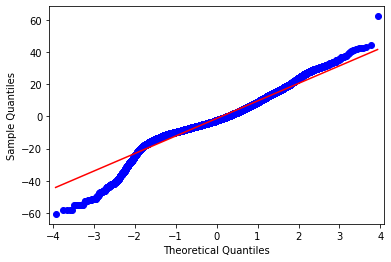

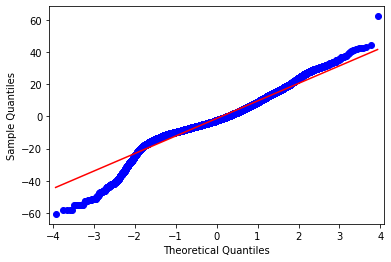

In [144]:
# QQplot
graphics.gofplots.qqplot(resid, line='r')

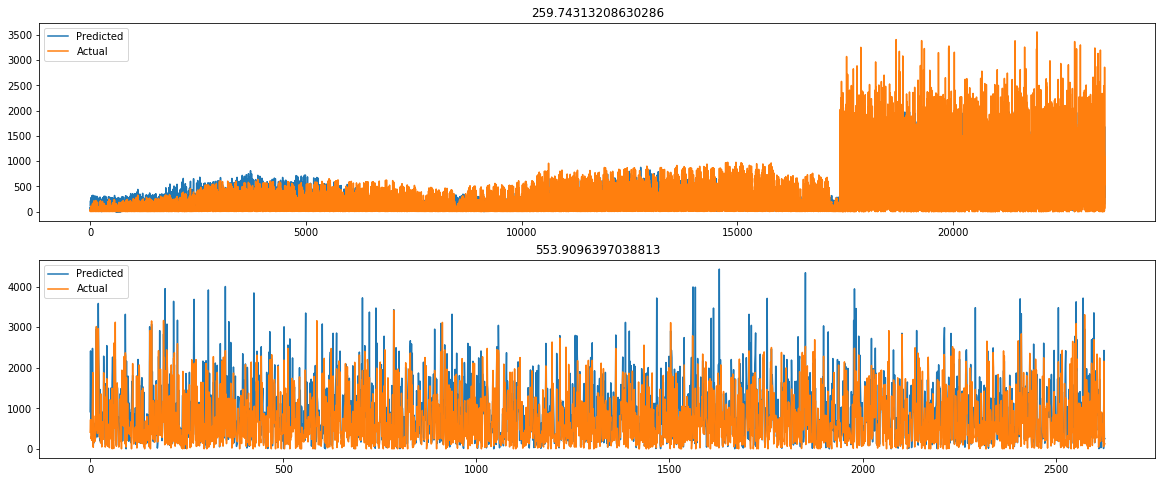

In [145]:
Y_train_pred = glm_poisson_simple.predict(X_train_combine)
Y_test_pred = glm_poisson_simple.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_combine)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_combine, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [146]:
print(glm_poisson_simple.aic)
print(glm_poisson_simple.deviance)

3119934.467610372
2962101.967785062


##### Poisson GLM model with interaction with korean data 

In [147]:
## add constant in X
X_train_kr = sm.add_constant(X_train_kr, prepend=False)

In [148]:
## fit model
glm_poisson_kr = glm(formula= formula_glm_kr, data = X_train_kr.join(Y_train_kr), family=sm.families.Poisson())
# add regularised term
glm_poisson_kr = glm_poisson_kr.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)
#glm_poisson_kr


In [149]:
print(glm_poisson_kr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                 6132
Model:                            GLM   Df Residuals:                     6044
Model Family:                 Poisson   Df Model:                           88
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -4.8470e+05
Date:                Fri, 10 Sep 2021   Deviance:                   9.2253e+05
Time:                        15:09:49   Pearson chi2:                 2.75e+07
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

/Users/demi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [150]:
# confidence interval
summary_df_kr = pd.DataFrame(glm_poisson_kr.summary2().tables[1])
confidence_kr = summary_df_kr.iloc[:,:1]

# calculate confidence interval
CI_kr = np.array([glm_poisson_kr.params - 2 * glm_poisson_kr.bse, glm_poisson_kr.params + 2 * glm_poisson_kr.bse]) # Compute 95% CI for parameters of Model 2.
confidence_kr['Low Interval'] = CI_kr[0] 
confidence_kr['High Interval'] = CI_kr[1]

# take exp
confidence_kr_exp = np.exp(confidence_kr)


/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
print('data dispersion:', glm_poisson_kr.pearson_chi2/6049)

data dispersion: 4542.796166552927


In [152]:
# for visualisation
nobs = glm_poisson_kr.nobs
y = Y_train_kr.values#/Y_train_combine.sum()
yhat = glm_poisson_kr.mu

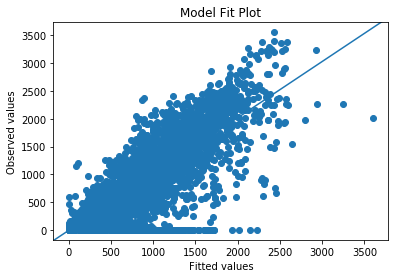

In [153]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [154]:
print(glm_poisson_kr.mu, len(glm_poisson_kr.mu))
print(glm_poisson_kr.resid_pearson, len(glm_poisson_kr.resid_pearson))

[3602.97125633  486.8778288   777.5520373  ...  414.98052352  374.12575057
  372.72255916] 6132
[-26.37197348   5.217338     2.63399546 ...  11.83145842   8.16211103
   9.54507472] 6132


Text(0.5, 0, 'Fitted values')

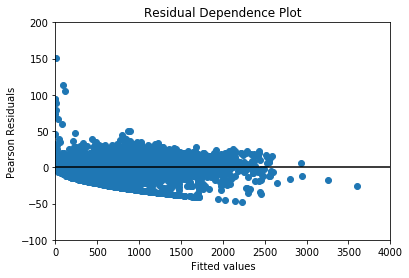

In [155]:
fig, ax = plt.subplots()
yhat = glm_poisson_kr.mu
ax.scatter(yhat, glm_poisson_kr.resid_pearson)
ax.hlines(0, 0, 4000)
ax.set_xlim(0, 4000)
ax.set_ylim(-100, 200)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

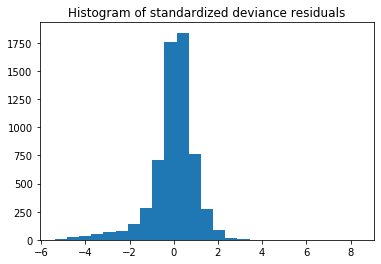

In [156]:
fig, ax = plt.subplots()

resid = glm_poisson_kr.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

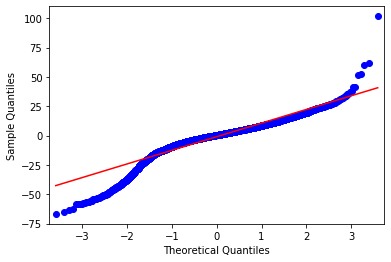

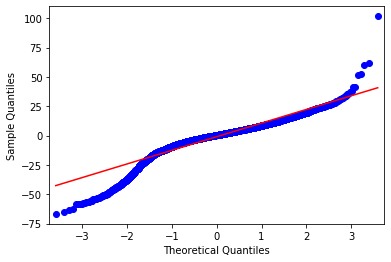

In [157]:
# QQplot
import scipy.stats as stats
graphics.gofplots.qqplot(resid, line='r')

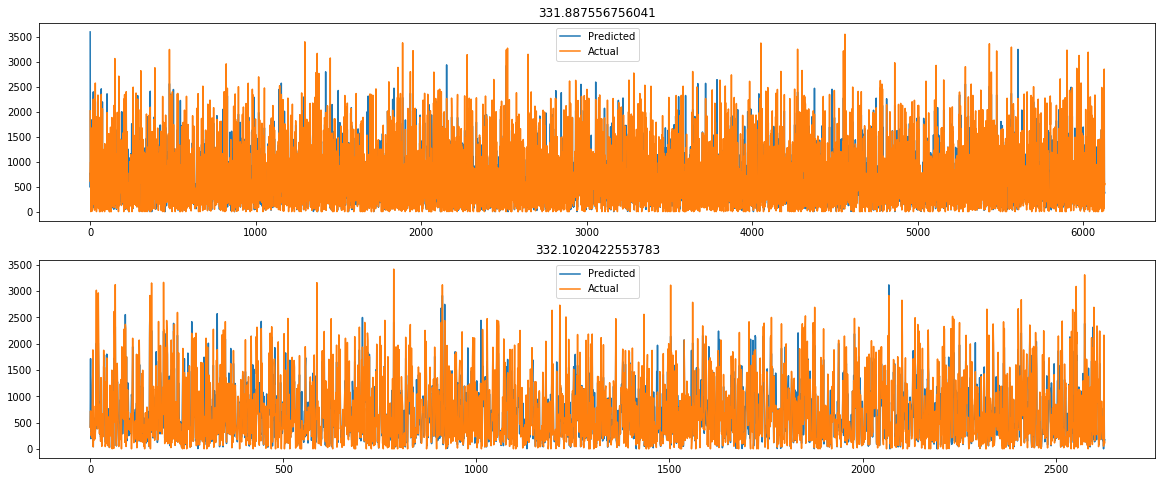

In [158]:
Y_train_pred = glm_poisson_kr.predict(X_train_kr)
Y_test_pred = glm_poisson_kr.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_kr)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_kr, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [159]:
print(glm_poisson_kr.aic)
print(glm_poisson_kr.deviance)

969570.6842317136
922532.989109083


##### Poisson GLM model without interaction with korean data 

In [160]:
## fit model
glm_poisson_kr_simple = glm(formula= formula_glm_simple, data = X_train_kr.join(Y_train_kr), family=sm.families.Poisson())
# add regularised term
glm_poisson_kr_simple = glm_poisson_kr_simple.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)



In [161]:
print(glm_poisson_kr_simple.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                 6132
Model:                            GLM   Df Residuals:                     6098
Model Family:                 Poisson   Df Model:                           34
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -5.5232e+05
Date:                Fri, 10 Sep 2021   Deviance:                   1.0578e+06
Time:                        15:09:59   Pearson chi2:                 1.51e+08
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0898      0.005   12

In [162]:
# confidence interval
summary_df_kr_simple = pd.DataFrame(glm_poisson_kr_simple.summary2().tables[1])
confidence_kr_simple = summary_df_kr_simple.iloc[:,:1]

# calculate confidence interval
CI_kr_simple = np.array([glm_poisson_kr_simple.params - 2 * glm_poisson_kr_simple.bse, glm_poisson_kr_simple.params + 2 * glm_poisson_kr_simple.bse]) # Compute 95% CI for parameters of Model 2.
confidence_kr_simple['Low Interval'] = CI_kr_simple[0] 
confidence_kr_simple['High Interval'] = CI_kr_simple[1]

# take exp
confidence_kr_simple_exp = np.exp(confidence_kr_simple)


/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/demi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [163]:
print('data dispersion:', glm_poisson_kr_simple.pearson_chi2/6099)

data dispersion: 24712.572762517357


In [164]:
nobs = glm_poisson_kr_simple.nobs
y = Y_train_kr.values
yhat = glm_poisson_kr_simple.mu

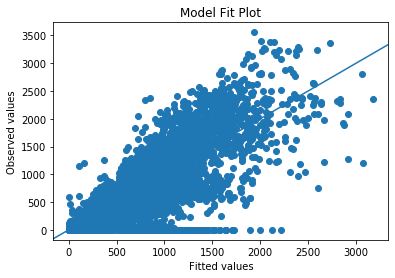

In [165]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [166]:
print(glm_poisson_kr_simple.mu, len(glm_poisson_kr_simple.mu))
print(glm_poisson_kr_simple.resid_pearson, len(glm_poisson_kr_simple.resid_pearson))

[2366.22215638  511.97648202  799.31817405 ...  468.38409836  303.3399355
  404.41788979] 6132
[-7.11749382  3.97860638  1.82800763 ...  8.66899143 13.12881494
  7.58732064] 6132


Text(0.5, 0, 'Fitted values')

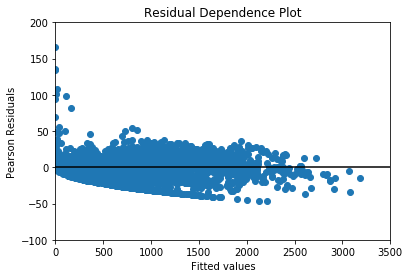

In [167]:
fig, ax = plt.subplots()
yhat = glm_poisson_kr_simple.mu
ax.scatter(yhat, glm_poisson_kr_simple.resid_pearson)
ax.hlines(0, 0, 3500)
ax.set_xlim(0, 3500)
ax.set_ylim(-100, 200)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

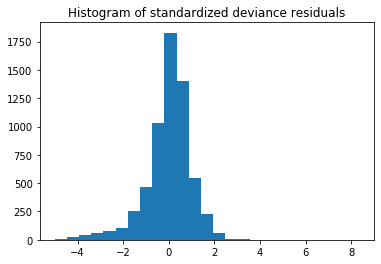

In [168]:
fig, ax = plt.subplots()

resid = glm_poisson_kr_simple.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

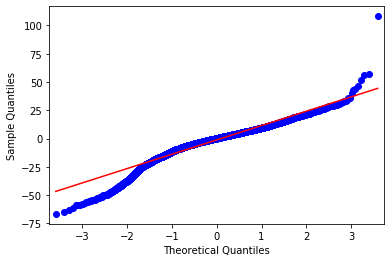

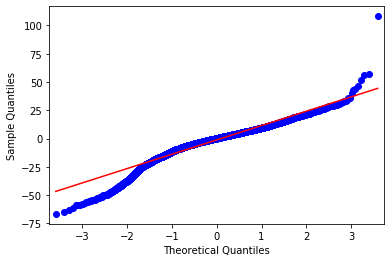

In [169]:
# QQplot
graphics.gofplots.qqplot(resid, line='r')

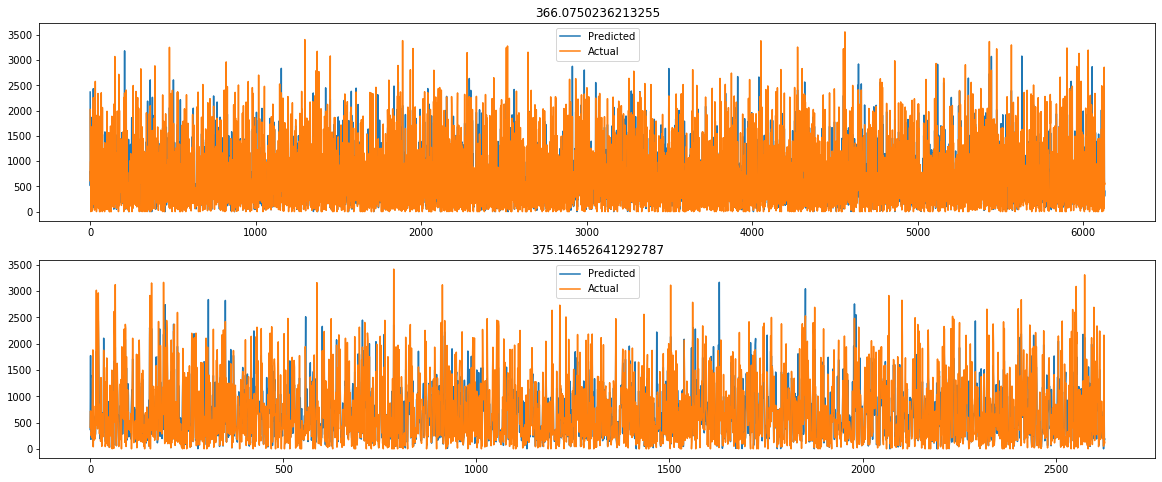

In [170]:
Y_train_pred = glm_poisson_kr_simple.predict(X_train_kr)
Y_test_pred = glm_poisson_kr_simple.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_kr)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_kr, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [171]:
print(glm_poisson_kr_simple.aic)
print(glm_poisson_kr_simple.deviance)

1104709.8703622022
1057780.1752395718


#### 2. Negative Binomial GLM
data dispersion exists in Poisson GLM
https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

1. fit Poisson regression model to get the vector of fitted value lambda
2. fit the aux OLS regrssion to get the value alpha
3. use the alpha from step 2 to fit NB2 model to the dataset
4. use the fitted NB2 model to make predictions
5. goodness fit test for NB2 model

##### NB GLM with Combined data with interaction

**Step 1**

In [172]:
## take the lambda from poisson GLM without L1 regularisation
glm_poisson = glm(formula= formula_glm, data = X_train_combine.join(Y_train_combine), 
                  family=sm.families.Poisson())
glm_poisson = glm_poisson.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [173]:
print(glm_poisson.summary())
print(glm_poisson.mu)
print(len(glm_poisson.mu))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                23511
Model:                            GLM   Df Residuals:                    23446
Model Family:                 Poisson   Df Model:                           65
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -1.2340e+06
Date:                Fri, 10 Sep 2021   Deviance:                   2.3102e+06
Time:                        15:10:45   Pearson chi2:                 6.84e+06
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.1394 

**step 2**

In [174]:
X_train_smf = X_train_combine.copy()
X_train_smf['BB_LAMBDA'] = glm_poisson.mu

In [175]:
X_train_smf['AUX_OLS_DEP'] = ((Y_train_combine-X_train_smf['BB_LAMBDA'])**2-X_train_smf['BB_LAMBDA'])/X_train_smf['BB_LAMBDA']

In [176]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [177]:
aux_olsr_results = smf.ols(ols_expr, X_train_smf).fit()

In [178]:
print(aux_olsr_results.params)

BB_LAMBDA    0.243728
dtype: float64


In [179]:
# if alpha is significant
print(aux_olsr_results.tvalues)

BB_LAMBDA    0.714867
dtype: float64


Check t value calculator (23511 samples -1 parameter alpha) = 23510
The critical t values at a 99% significance level is T-Value (right-tailed): 2.326506. The t value is far less than the t value of alpha, so we can conclude that alpha value is significant statistically.

**step 3**

In [180]:
aux_olsr_results.params[0]

0.2437278068116563

In [181]:
glm_nb = glm(formula= formula_glm, data = X_train_combine.join(Y_train_combine), family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

glm_nb = glm_nb.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [182]:
print(glm_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                23511
Model:                            GLM   Df Residuals:                    23447
Model Family:        NegativeBinomial   Df Model:                           64
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -1.4497e+05
Date:                Fri, 10 Sep 2021   Deviance:                       47081.
Time:                        15:11:33   Pearson chi2:                 3.70e+04
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.6626 

In [183]:
nobs = glm_nb.nobs
y = Y_train_combine.values
yhat = glm_nb.mu

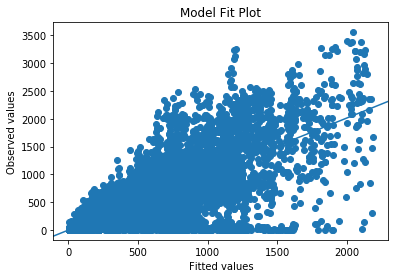

In [184]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [185]:
print(glm_nb.mu, len(glm_nb.mu))
print(glm_nb.resid_pearson, len(glm_nb.resid_pearson))

[ 31.13667226  19.50899561  13.59507146 ... 350.0881481  770.04160949
 822.50686361] 23511
[-0.92560613  1.93387089  2.4034143  ...  1.75969032 -0.62449967
 -0.65223361] 23511


Text(0.5, 0, 'Fitted values')

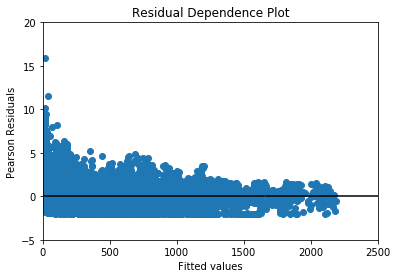

In [186]:
fig, ax = plt.subplots()
yhat = glm_nb.mu
ax.scatter(yhat, glm_nb.resid_pearson)
ax.hlines(0, 0, 2500)
ax.set_xlim(0, 2500)
ax.set_ylim(-5, 20)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

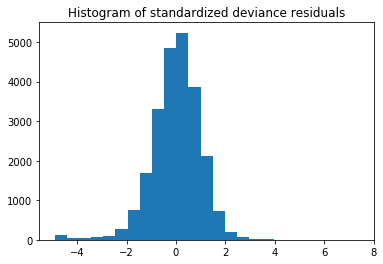

In [187]:


fig, ax = plt.subplots()

resid = glm_nb.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

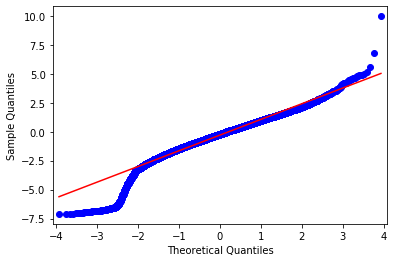

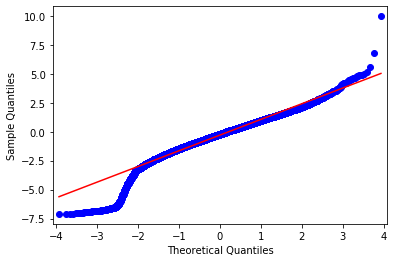

In [188]:

graphics.gofplots.qqplot(resid, line='r')

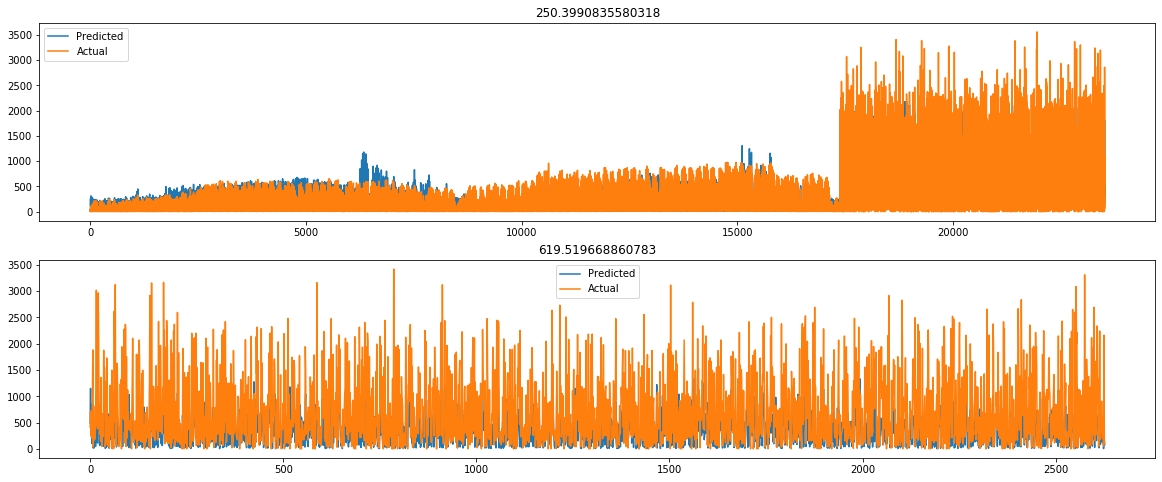

In [189]:
Y_train_pred = glm_nb.predict(X_train_combine)
Y_test_pred = glm_nb.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_combine)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_combine, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [190]:
print(glm_nb.aic)
print(glm_nb.deviance)

290069.05790007557
47081.07232019424


##### NB GLM with combined data without interaction

**step 1**

In [191]:
## take the lambda from poisson GLM without L1 regularisation
glm_poisson_simple = glm(formula= formula_glm_simple, data = X_train_combine.join(Y_train_combine), 
                  family=sm.families.Poisson())#.fit()
glm_poisson_simple = glm_poisson_simple.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [192]:
print(glm_poisson_simple.summary())
print(glm_poisson_simple.mu)
print(len(glm_poisson_simple.mu))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                23511
Model:                            GLM   Df Residuals:                    23476
Model Family:                 Poisson   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -1.5599e+06
Date:                Fri, 10 Sep 2021   Deviance:                   2.9621e+06
Time:                        15:11:58   Pearson chi2:                 3.21e+07
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.8241      0.002   23

**step 2**

In [193]:
X_train_smf = X_train_combine.copy()
X_train_smf['BB_LAMBDA'] = glm_poisson_simple.mu

In [194]:
X_train_smf['AUX_OLS_DEP'] = ((Y_train_combine-X_train_smf['BB_LAMBDA'])**2-X_train_smf['BB_LAMBDA'])/X_train_smf['BB_LAMBDA']



In [195]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [196]:
aux_olsr_results = smf.ols(ols_expr, X_train_smf).fit()

In [197]:
print(aux_olsr_results.params)

BB_LAMBDA    0.312797
dtype: float64


In [198]:
# if alpha is significant
print(aux_olsr_results.tvalues)


BB_LAMBDA    0.247669
dtype: float64


Check t value calculator (23511 samples -1 parameter alpha) = 23510
The critical t values at a 99% significance level is T-Value (right-tailed): 2.326506. The t value is far less than the t value of alpha, so we can conclude that alpha value is NOT significant statistically.

**step 3**

In [199]:
aux_olsr_results.params[0]

0.312796671612011

In [200]:
glm_nb_simple = glm(formula= formula_glm_simple, data = X_train_combine.join(Y_train_combine), family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

glm_nb_simple = glm_nb_simple.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [201]:
print(glm_nb_simple.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                23511
Model:                            GLM   Df Residuals:                    23476
Model Family:        NegativeBinomial   Df Model:                           35
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -1.4654e+05
Date:                Fri, 10 Sep 2021   Deviance:                       44559.
Time:                        15:12:21   Pearson chi2:                 3.39e+04
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.4811      0.020    2

In [202]:
nobs = glm_nb_simple.nobs
y = Y_train_combine.values
yhat = glm_nb_simple.mu

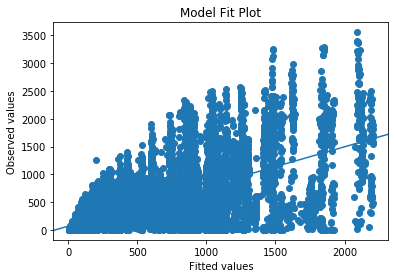

In [203]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [204]:
print(glm_nb_simple.mu, len(glm_nb_simple.mu))
print(glm_nb_simple.resid_pearson, len(glm_nb_simple.resid_pearson))

[  37.27424195   24.45341021   16.37945688 ...  204.44546446  932.18468003
 1739.27649484] 23511
[-0.97936718  1.06901512  1.55972726 ...  3.91861283 -0.76627383
 -1.2142849 ] 23511


Text(0.5, 0, 'Fitted values')

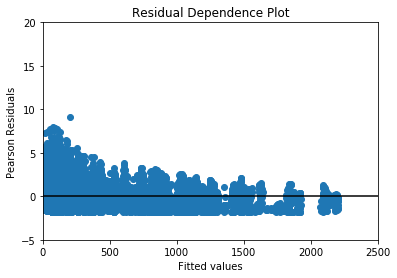

In [205]:
fig, ax = plt.subplots()
yhat = glm_nb_simple.mu
ax.scatter(yhat, glm_nb_simple.resid_pearson)
ax.hlines(0, 0, 2500)
ax.set_xlim(0, 2500)
ax.set_ylim(-5, 20)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

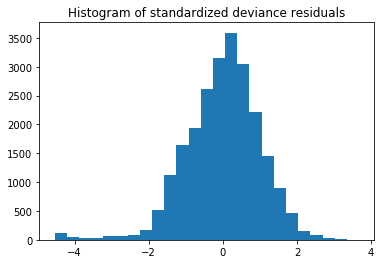

In [206]:


fig, ax = plt.subplots()

resid = glm_nb_simple.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

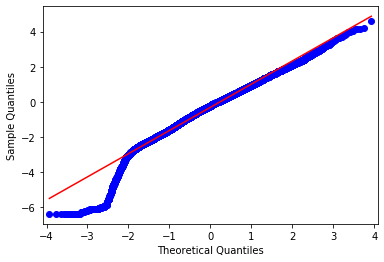

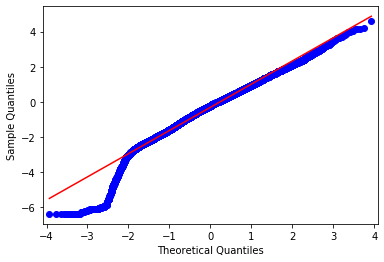

In [207]:

graphics.gofplots.qqplot(resid, line='r')

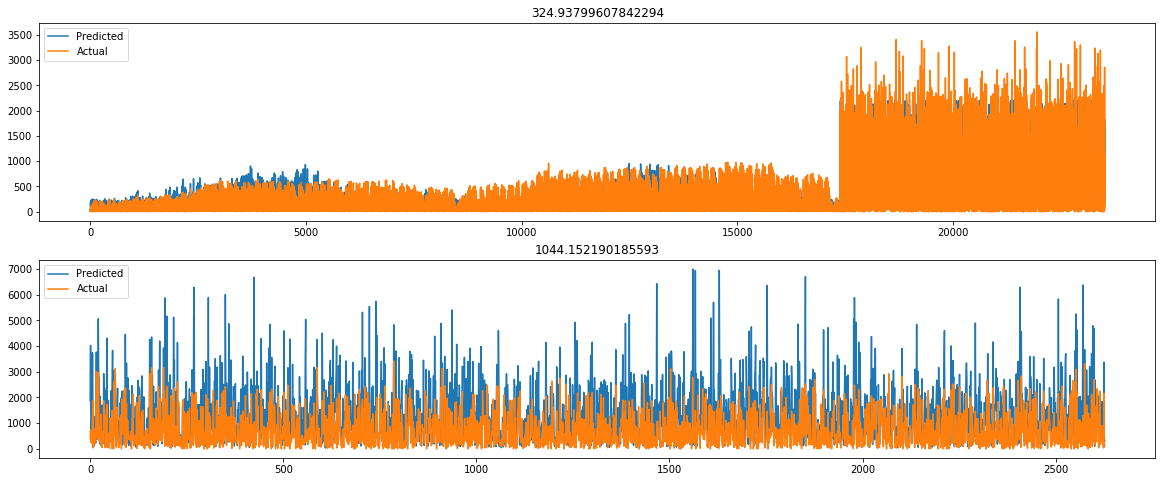

In [208]:
Y_train_pred = glm_nb_simple.predict(X_train_combine)
Y_test_pred = glm_nb_simple.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_combine)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_combine, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [209]:
print(glm_nb_simple.aic)
print(glm_nb_simple.deviance)

293148.41229758144
44559.487015212304


##### NB GLM with KR data with interaction

**step 1**

In [210]:
## take the lambda from poisson GLM without L1 regularisation
glm_poisson_kr = glm(formula= formula_glm_kr, data = X_train_kr.join(Y_train_kr), 
                  family=sm.families.Poisson())#.fit()
glm_poisson_kr = glm_poisson_kr.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [211]:
print(glm_poisson_kr.summary())
print(glm_poisson_kr.mu)
print(len(glm_poisson_kr.mu))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                 6132
Model:                            GLM   Df Residuals:                     6044
Model Family:                 Poisson   Df Model:                           88
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -4.8470e+05
Date:                Fri, 10 Sep 2021   Deviance:                   9.2253e+05
Time:                        15:12:42   Pearson chi2:                 2.75e+07
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**step 2**

In [212]:
X_train_smf = X_train_kr.copy()
X_train_smf['BB_LAMBDA'] = glm_poisson_kr.mu

X_train_smf['AUX_OLS_DEP'] = X_train_smf.apply(
    lambda x:((Y_train_combine - x['BB_LAMBDA'])**2 - 
              x['BB_LAMBDA'])/x['BB_LAMBDA'], axis = 1)

In [213]:
X_train_smf['AUX_OLS_DEP'] = ((Y_train_kr-X_train_smf['BB_LAMBDA'])**2-X_train_smf['BB_LAMBDA'])/X_train_smf['BB_LAMBDA']



In [214]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [215]:
aux_olsr_results = smf.ols(ols_expr, X_train_smf).fit()

In [216]:
print(aux_olsr_results.params)

BB_LAMBDA    0.141198
dtype: float64


In [217]:
# if alpha is significant
print(aux_olsr_results.tvalues)


BB_LAMBDA    0.039399
dtype: float64


Check t value calculator (6132 samples -1 parameter alpha) = 6131

The critical t values at a 99% significance level is T-Value (right-tailed): 2.326956. 

The t value is far less than the t value of alpha, so we can conclude that alpha value is NOT significant statistically.

**step 3**

In [218]:
aux_olsr_results.params[0]

0.1411981834099822

In [219]:
glm_nb_kr = glm(formula= formula_glm_kr, data = X_train_kr.join(Y_train_kr), family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

glm_nb_kr = glm_nb_kr.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)
glm_nb_kr

In [220]:
print(glm_nb_kr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                 6132
Model:                            GLM   Df Residuals:                     6049
Model Family:        NegativeBinomial   Df Model:                           83
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:                -47730.
Date:                Fri, 10 Sep 2021   Deviance:                       23865.
Time:                        15:13:01   Pearson chi2:                 1.14e+04
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [221]:
nobs = glm_nb_kr.nobs
y = Y_train_kr.values
yhat = glm_nb_kr.mu

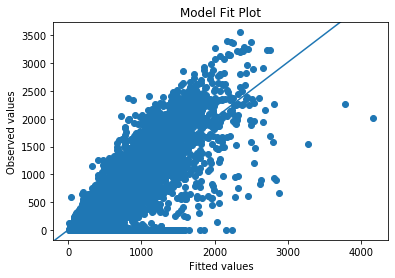

In [222]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [223]:
print(glm_nb_kr.mu, len(glm_nb_kr.mu))
print(glm_nb_kr.resid_pearson, len(glm_nb_kr.resid_pearson))

[4164.6100374   496.24418682  746.99021579 ...  427.43752944  417.25289317
  347.35933116] 6132
[-1.36927436  0.56314095  0.36880402 ...  1.41139726  0.72572655
  1.59000748] 6132


Text(0.5, 0, 'Fitted values')

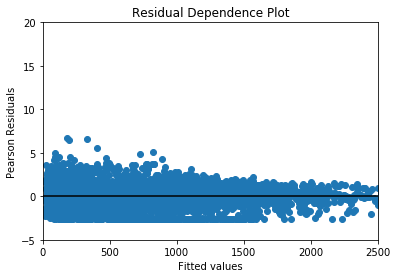

In [224]:
fig, ax = plt.subplots()
yhat = glm_nb_kr.mu
ax.scatter(yhat, glm_nb_kr.resid_pearson)
ax.hlines(0, 0, 2500)
ax.set_xlim(0, 2500)
ax.set_ylim(-5, 20)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

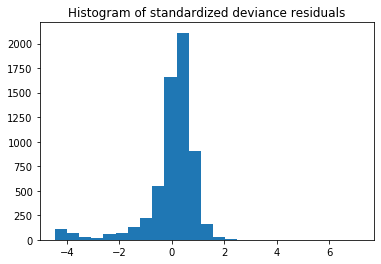

In [225]:
fig, ax = plt.subplots()

resid = glm_nb_kr.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

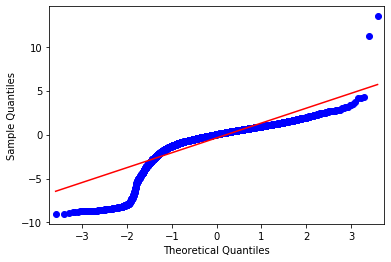

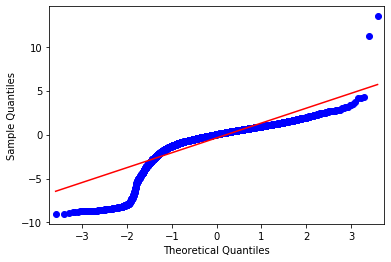

In [226]:
graphics.gofplots.qqplot(resid, line='r')

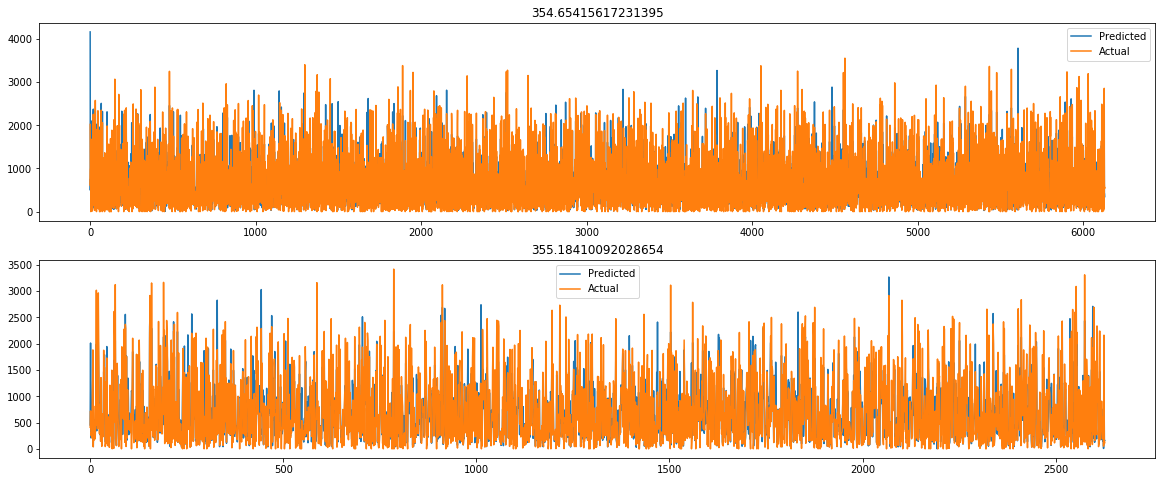

In [227]:
Y_train_pred = glm_nb_kr.predict(X_train_kr)
Y_test_pred = glm_nb_kr.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_kr)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_kr, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [228]:
print(glm_nb_kr.aic)
print(glm_nb_kr.deviance)

95627.10950231439
23864.991425533884


##### NB GLM with KR data without interaction

**step 1**

In [229]:
## take the lambda from poisson GLM without L1 regularisation
glm_poisson_kr_simple = glm(formula= formula_glm_simple, data = X_train_kr.join(Y_train_kr), 
                  family=sm.families.Poisson())#.fit()
glm_poisson_kr_simple = glm_poisson_kr_simple.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)

In [230]:
print(glm_poisson_kr_simple.summary())
print(glm_poisson_kr_simple.mu)
print(len(glm_poisson_kr_simple.mu))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                 6132
Model:                            GLM   Df Residuals:                     6098
Model Family:                 Poisson   Df Model:                           34
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:            -5.5232e+05
Date:                Fri, 10 Sep 2021   Deviance:                   1.0578e+06
Time:                        15:13:10   Pearson chi2:                 1.51e+08
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0898      0.005   12

**step 2**

In [231]:
X_train_smf = X_train_kr.copy()
X_train_smf['BB_LAMBDA'] = glm_poisson_kr_simple.mu

In [232]:
X_train_smf['AUX_OLS_DEP'] = ((Y_train_kr-X_train_smf['BB_LAMBDA'])**2-X_train_smf['BB_LAMBDA'])/X_train_smf['BB_LAMBDA']



In [233]:
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

In [234]:
X_train_smf['AUX_OLS_DEP'].values

array([ 49.65871826,  14.82930872,   2.34161191, ...,  74.15141243,
       171.36578168,  56.56743444])

In [235]:
aux_olsr_results = smf.ols(ols_expr, X_train_smf).fit()

In [236]:
print(aux_olsr_results.params)

BB_LAMBDA    0.175492
dtype: float64


In [237]:
# if alpha is significant
print(aux_olsr_results.tvalues)


BB_LAMBDA    0.007659
dtype: float64


Check t value calculator (6132 samples -1 parameter alpha) = 6131
The critical t values at a 99% significance level is T-Value (right-tailed): 2.326956. The t value is far less than the t value of alpha, so we can conclude that alpha value is NOT significant statistically.

**step 3**

In [238]:
aux_olsr_results.params[0]

0.1754924755624763

In [239]:
glm_nb_kr_simple = glm(formula= formula_glm_simple, data = X_train_kr.join(Y_train_kr), family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

glm_nb_kr_simple = glm_nb_kr_simple.fit_regularized(method='elastic_net', L1_wt = 1, alpha=alpha_glm,refit=True)
glm_nb_kr_simple

In [240]:
print(glm_nb_kr_simple.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                 6132
Model:                            GLM   Df Residuals:                     6099
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    log   Scale:                          1.0000
Method:                   elastic_net   Log-Likelihood:                -46953.
Date:                Fri, 10 Sep 2021   Deviance:                       21030.
Time:                        15:13:17   Pearson chi2:                 1.06e+04
No. Iterations:                    50                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.0186      0.048    1

In [241]:
nobs = glm_nb_kr_simple.nobs
y = Y_train_kr.values
yhat = glm_nb_kr_simple.mu

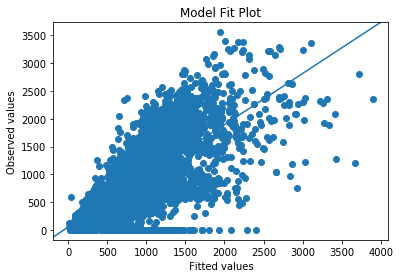

In [242]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [243]:
print(glm_nb_kr_simple.mu, len(glm_nb_kr_simple.mu))
print(glm_nb_kr_simple.resid_pearson, len(glm_nb_kr_simple.resid_pearson))

[2573.09243324  536.22596807  720.87465183 ...  503.03601954  405.75603046
  376.89655194] 6132
[-0.51254586  0.29126078  0.42920342 ...  0.72179669  0.73754429
  1.13217135] 6132


Text(0.5, 0, 'Fitted values')

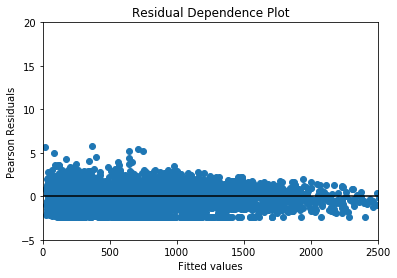

In [244]:
fig, ax = plt.subplots()
yhat = glm_nb_kr_simple.mu
ax.scatter(yhat, glm_nb_kr_simple.resid_pearson)
ax.hlines(0, 0, 2500)
ax.set_xlim(0, 2500)
ax.set_ylim(-5, 20)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

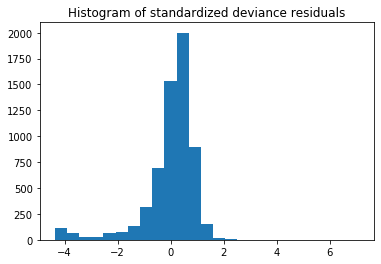

In [245]:
fig, ax = plt.subplots()

resid = glm_nb_kr_simple.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

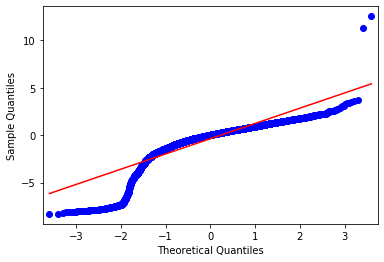

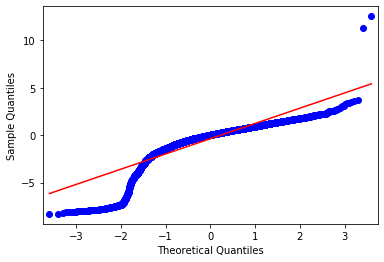

In [246]:
graphics.gofplots.qqplot(resid, line='r')

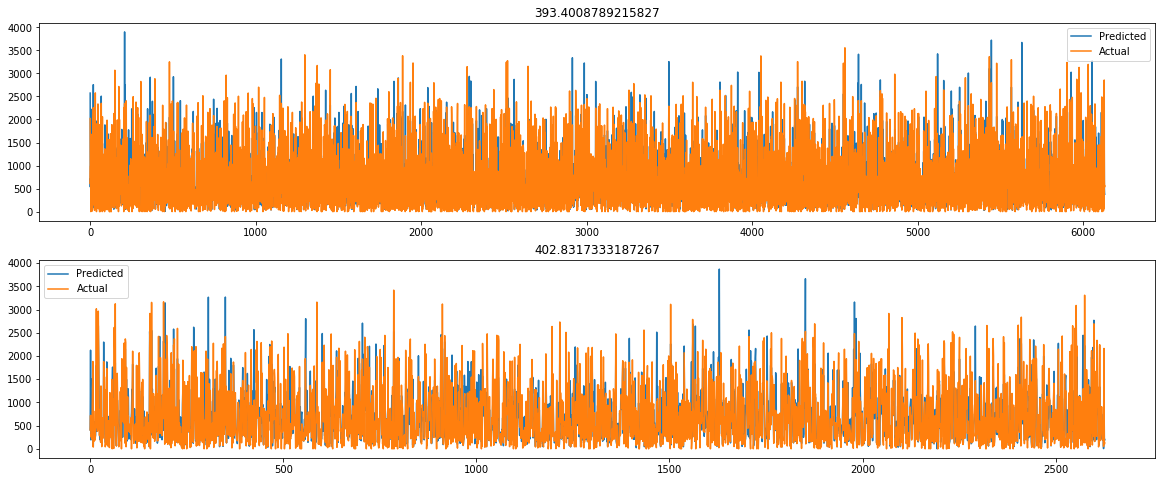

In [247]:
Y_train_pred = glm_nb_kr_simple.predict(X_train_kr)
Y_test_pred = glm_nb_kr_simple.predict(X_test)
rmse_train = np.sqrt(np.mean((Y_train_pred - Y_train_kr)**2))
rmse_test = np.sqrt(np.mean((Y_test_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
ax.plot(np.arange(len(Y_train_pred)), Y_train_kr, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
ax.plot(np.arange(len(Y_test_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend();

In [248]:
print(glm_nb_kr_simple.aic)
print(glm_nb_kr_simple.deviance)

93974.88489800473
21030.342911921853
